In [1]:
# Importando librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import scipy. stats  as stats

from numpy.random import seed, randn
from scipy.stats import shapiro
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import RandomUnderSampler


from sklearn.metrics import classification_report, precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

# Data Cleaning

## Describiendo y Uniendo las diferentes tablas

In [2]:
# Cargando el archivo de usuarios
# Cargar el archivo Linea1-Usuarios y se usa el metodo DROP para eliminar las columnas innecesarias ['IND_ALTA','FEC_ALTA','USU_TELF','IP_Country','IP_Area','TIPOEMAIL']
usuarios = pd.read_csv('Linea1-Usuarios.txt', sep=';', encoding='latin-1').drop(['IND_ALTA','FEC_ALTA','USU_TELF','IP_Country','IP_Area','TIPOEMAIL'], axis=1)
# Transformar valores de FEC_CLIENTE y FEC_REGISTRO a tipo datatime[64]
usuarios['FEC_CLIENTE'] = pd.to_datetime(usuarios['FEC_CLIENTE'])
usuarios['FEC_REGISTRO'] = pd.to_datetime(usuarios['FEC_REGISTRO'])
usuarios.replace({pd.NaT: None}, inplace=True)
# Reemplazar los valores nulos de FEC_CLIENTE que están con IND_CLIENTE 1, con los valores en FEC_REGISTRO para las mismas filas
usuarios.loc[(usuarios['IND_CLIENTE'] == 1) & (pd.isnull(usuarios['FEC_CLIENTE'])),['FEC_CLIENTE']] = usuarios.loc[(usuarios['IND_CLIENTE'] == 1) & (pd.isnull(usuarios['FEC_CLIENTE'])),['FEC_REGISTRO']].values
# Mostrar los primeros 5 registros de la tabla usuarios
usuarios.head()

,IDUSUARIO,TIPOUSUARIO,FEC_REGISTRO,CANAL_REGISTRO,IND_CLIENTE,BONDAD_EMAIL,IPCASOS,USU_TIPO,USU_TAMANIO,USU_CIIU,USU_ESTADO,USU_DEPARTAMENTO,FEC_CLIENTE
0,"8107310,00",PF,2019-10-22 00:00:00,3.0,0,0,1,None,None,None,None,None,None
1,"7784565,00",PJ,2019-05-14 00:00:00,3.0,0,20,1,SOCIEDAD COMERCIAL/INDUSTRIAL,PQ,N7820,ACTIVA,QUINDIO,None
2,"7718778,00",PJ,2019-09-04 00:00:00,7.0,0,20,1,SOCIEDAD COMERCIAL/INDUSTRIAL,MC,G4774,ACTIVA,ATLANTICO,None
3,"7952765,00",PX,2019-12-08 00:00:00,3.0,0,20,1,None,None,None,None,None,None
4,"7855424,00",PJ,2019-06-21 00:00:00,7.0,0,20,1,EMPRESARIO INDIVIDUAL,MC,N8299,CANCELACIÓN,ATLANTICO,None


In [3]:
# Relación del Indicador cliente e Indicador Alta
usuarios2 = pd.read_csv('Linea1-Usuarios.txt', sep=';', encoding='latin-1')
tabla_dobleEntrada = pd.crosstab(usuarios2['IND_ALTA'],usuarios2['IND_CLIENTE'],margins=False)
# print(tabla_dobleEntrada)
n = len(usuarios2. index)
# print(n)
minimo = min(usuarios2['IND_ALTA'].nunique(),usuarios2['IND_CLIENTE'].nunique())-1
# print(minimo)
X2 = stats.chi2_contingency(tabla_dobleEntrada,correction=False)[0]
# print(X2)
V = np. sqrt ((X2 / n) / minimo)
print('Correlación C Cramer BONDAD_EMAIL-TIPOUSUARIO: ',V)

Correlación C Cramer BONDAD_EMAIL-TIPOUSUARIO:  0.8389400232701579


In [4]:
# Descripcion del tipo de dato por columna para el dataframe usuarios
usuarios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367705 entries, 0 to 367704
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   IDUSUARIO         367705 non-null  object 
 1   TIPOUSUARIO       367705 non-null  object 
 2   FEC_REGISTRO      367705 non-null  object 
 3   CANAL_REGISTRO    360171 non-null  float64
 4   IND_CLIENTE       367705 non-null  int64  
 5   BONDAD_EMAIL      367705 non-null  int64  
 6   IPCASOS           367705 non-null  int64  
 7   USU_TIPO          84114 non-null   object 
 8   USU_TAMANIO       84116 non-null   object 
 9   USU_CIIU          84116 non-null   object 
 10  USU_ESTADO        84116 non-null   object 
 11  USU_DEPARTAMENTO  90508 non-null   object 
 12  FEC_CLIENTE       2619 non-null    object 
dtypes: float64(1), int64(3), object(9)
memory usage: 36.5+ MB


In [5]:
# Cargando el archivo de consumos promocionales
# Cargar el archivo Linea1-Consumos Promocionales y se usa el metodo DROP para eliminar las columnas innecesarias (['IDCONSUMO', 'IDGRUPOPROD', 'IDPRODUCTO', 'EMPCONSUL_ID','EMPCONSUL_CIIU','EMPCONSUL_PROV','EMPCONSUL_EST', 'DESCGRUPOPROD']

consumo = pd.read_csv('Linea1-Consumos Promocionales.txt', sep=";", encoding='latin-1').drop(['IDCONSUMO', 'IDGRUPOPROD', 'IDPRODUCTO', 'EMPCONSUL_ID','EMPCONSUL_CIIU','EMPCONSUL_PROV','EMPCONSUL_EST', 'DESCGRUPOPROD'], axis=1)
# Convertir los valores de la variable FECHACONSUMO a su version en datatime[64]
consumo['FECHACONSUMO'] = pd.to_datetime(consumo['FECHACONSUMO'])
# Mostrar los primeros 5 registros de la tabla consumo
consumo.head()

,IDUSUARIO,DESCPRODUCTO,FECHACONSUMO
0,"6868835,00",Perfil Promocional,2018-01-01
1,"6868838,00",Perfil Promocional,2018-01-01
2,"6868841,00",Perfil Promocional,2018-01-01
3,"6868844,00",Perfil Promocional,2018-01-01
4,"6868841,00",Ficha Básica,2018-01-01


In [6]:
# Descripcion del tipo de variables por columna para el dataframe consumo
consumo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 796737 entries, 0 to 796736
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   IDUSUARIO     796737 non-null  object        
 1   DESCPRODUCTO  796737 non-null  object        
 2   FECHACONSUMO  796737 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 18.2+ MB


In [7]:
# Mostrando los tipos de consumo
print(consumo.groupby('DESCPRODUCTO').size())

DESCPRODUCTO
Ficha Básica          372509
Perfil Promocional    424228
dtype: int64


In [8]:
# Operacion de merge entre el df usuarios y consumo bajo el metodo de left join en el ID IDUSUARIO
usuarios_consumo = pd.merge(usuarios, consumo, on=['IDUSUARIO'], how='left')
# Organizar las columnas del resultado de merge por la variable de IDUSUARIO
usuarios_consumo = usuarios_consumo.sort_values('IDUSUARIO')


In [9]:
usuarios_consumo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 796768 entries, 64249 to 234012
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   IDUSUARIO         796768 non-null  object        
 1   TIPOUSUARIO       796768 non-null  object        
 2   FEC_REGISTRO      796768 non-null  object        
 3   CANAL_REGISTRO    771243 non-null  float64       
 4   IND_CLIENTE       796768 non-null  int64         
 5   BONDAD_EMAIL      796768 non-null  int64         
 6   IPCASOS           796768 non-null  int64         
 7   USU_TIPO          156296 non-null  object        
 8   USU_TAMANIO       156300 non-null  object        
 9   USU_CIIU          156300 non-null  object        
 10  USU_ESTADO        156300 non-null  object        
 11  USU_DEPARTAMENTO  168414 non-null  object        
 12  FEC_CLIENTE       13595 non-null   object        
 13  DESCPRODUCTO      796737 non-null  object        
 14  

In [10]:
# Filtrar tabla de usuarios y consumo por filas en las que la fehc ade consumo sea antes o igual a la fecha de clientes
usuarios_consumo_c_1 = usuarios_consumo.loc[usuarios_consumo['FECHACONSUMO'] <= usuarios_consumo['FEC_CLIENTE']]

# Mensaje para mostrar los primeros 5 registros de la tabla usuarios_consumo con el filtro de fechas aplicados
print('IND_CLIENTE == 1', '\n')
print(usuarios_consumo_c_1.head())

# Filtrar usuarios en los que el indicativo de cliente sea igual a 0
usuarios_consumo_c_0 = usuarios_consumo.loc[(usuarios_consumo['IND_CLIENTE'] == 0)
                                            , :]

# Mensaje para mostrar los primeros 5 registros de la tabla usuarios_consumo con el filtro de indicativo de cliente aplicado (Iguales a 0)
print('\n\n')
print('IND_CLIENTE == 0', '\n')
print(usuarios_consumo_c_0.head())


IND_CLIENTE == 1 

         IDUSUARIO TIPOUSUARIO         FEC_REGISTRO  CANAL_REGISTRO  \
572940  6869752,00          PJ  2018-02-01 00:00:00             3.0   
572939  6869752,00          PJ  2018-02-01 00:00:00             3.0   
572942  6869752,00          PJ  2018-02-01 00:00:00             3.0   
572941  6869752,00          PJ  2018-02-01 00:00:00             3.0   
751540  6869761,00          PJ  2018-02-01 00:00:00             6.0   

        IND_CLIENTE  BONDAD_EMAIL  IPCASOS                       USU_TIPO  \
572940            1            20        1  SOCIEDAD COMERCIAL/INDUSTRIAL   
572939            1            20        1  SOCIEDAD COMERCIAL/INDUSTRIAL   
572942            1            20        1  SOCIEDAD COMERCIAL/INDUSTRIAL   
572941            1            20        1  SOCIEDAD COMERCIAL/INDUSTRIAL   
751540            1             0        3  SOCIEDAD COMERCIAL/INDUSTRIAL   

       USU_TAMANIO USU_CIIU USU_ESTADO USU_DEPARTAMENTO          FEC_CLIENTE  \
572940     

In [11]:
# Insertar al final de la tabla de usuario_consumos (Usuarios con indicativo 1) nueva columna llamada  'DESC_FICHABASICA' donde
# aparecerpa el valor de 1 si el usuario consumio proudcto con etiqueta 'Ficha basica' y 0 en el caso contrario
usuarios_consumo_c_1.insert(len(usuarios_consumo_c_1.columns),
                            'DESC_FICHABASICA', 
                            (usuarios_consumo_c_1.loc[:,['DESCPRODUCTO']] == 'Ficha Básica').astype(int))
                            
# Insertar al final de la tabla de usuario_consumos (Usuarios con indicativo 1) nueva columna llamada  'DESC_PERFILPROMOCIONAL' donde
# aparecerpa el valor de 1 si el usuario consumio proudcto con etiqueta 'Perfil Promocional' y 0 en el caso contrario
usuarios_consumo_c_1.insert(len(usuarios_consumo_c_1.columns),
                            'DESC_PERFILPROMOCIONAL',
                            (usuarios_consumo_c_1.loc[:,['DESCPRODUCTO']] == 'Perfil Promocional').astype(int))

# Eliminar columna de DESCPRODUCTO de la tabla de usuarios con indicativo 1
usuarios_consumo_c_1 = usuarios_consumo_c_1.drop(['DESCPRODUCTO'], axis=1)


# Insertar al final de la tabla de usuario_consumos (Usuarios con indicativo 0) nueva columna llamada  'DESC_FICHABASICA' donde
# aparecerpa el valor de 1 si el usuario consumio proudcto con etiqueta 'Ficha basica' y 0 en el caso contrario
usuarios_consumo_c_0.insert(len(usuarios_consumo_c_0.columns),
                            'DESC_FICHABASICA', 
                            (usuarios_consumo_c_0.loc[:,['DESCPRODUCTO']] == 'Ficha Básica').astype(int))
                            

# Insertar al final de la tabla de usuario_consumos (Usuarios con indicativo 0) nueva columna llamada  'DESC_PERFILPROMOCIONAL' donde
# aparecerpa el valor de 1 si el usuario consumio proudcto con etiqueta 'Perfil Promocional' y 0 en el caso contrario
usuarios_consumo_c_0.insert(len(usuarios_consumo_c_0.columns),
                            'DESC_PERFILPROMOCIONAL',
                            (usuarios_consumo_c_0.loc[:,['DESCPRODUCTO']] == 'Perfil Promocional').astype(int))

# Eliminar columna de DESCPRODUCTO de la tabla de usuarios con indicativo 0
usuarios_consumo_c_0 = usuarios_consumo_c_0.drop(['DESCPRODUCTO'], axis=1)

In [12]:
# Elección de que valores van a quedar por columna al aplicar la tabla dinamica (Groupby)
# 'first' indica que para al columna se mantendrá el primer valor encontrado
# 'sum' indica que para esa columna se sumaran los valores en la tabla dinamica
# 'count' indica que para esa columna se contarán los valores en la tabla dinamica
dicc = {
    'TIPOUSUARIO': 'first',
    'CANAL_REGISTRO': 'first',
    'IND_CLIENTE': 'first',
    'BONDAD_EMAIL': 'first',
    'IPCASOS': 'first',
    'USU_TIPO': 'first',
    'USU_TAMANIO': 'first',
    'USU_CIIU': 'first',
    'USU_ESTADO': 'first',
    'USU_DEPARTAMENTO': 'first',
    'FEC_CLIENTE': 'first',
    'DESC_FICHABASICA':'sum',
    'DESC_PERFILPROMOCIONAL':'sum',
    'FECHACONSUMO': 'count',
}

# Aplicar tabla dinámica (Al datarframe con usuarios con indicativo 1) por IDUSUARIO y realizar 
# operacion de agregación según las elecciones anteriores
usuarios_consumo_c_1 = usuarios_consumo_c_1.groupby('IDUSUARIO').agg(dicc).reset_index()
# Reemplzar el nombre de la columna FEHCACONSUMO por CONSUMOSTOTAL
usuarios_consumo_c_1 = usuarios_consumo_c_1.rename(columns={'FECHACONSUMO': 'CONSUMOSTOTAL'})

# Aplicar tabla dinámica (Al datarframe con usuarios con indicativo 0) por IDUSUARIO y realizar 
# operacion de agregación según las elecciones anteriores
usuarios_consumo_c_0 = usuarios_consumo_c_0.groupby('IDUSUARIO').agg(dicc).reset_index()
# Reemplzar el nombre de la columna FEHCACONSUMO por CONSUMOSTOTAL
usuarios_consumo_c_0 = usuarios_consumo_c_0.rename(columns={'FECHACONSUMO': 'CONSUMOSTOTAL'})

In [13]:
# Cargando el archivo de Linea1-Logins
logins = pd.read_csv('Linea1-Logins.txt', sep=';', encoding='latin-1')
# Reemplazar los valores de FECHALOGIN por su version en datatime[64]
logins['FECHALOGIN'] = pd.to_datetime(logins['FECHALOGIN'])
# Mostrar los primeros 5 registros de la tabla logins
logins.head()

,IDUSUARIO,FECHALOGIN
0,"7339406,00",2018-08-31
1,"7339406,00",2018-04-09
2,"7339406,00",2018-04-09
3,"7966293,00",2019-10-10
4,"7694472,00",2019-03-28


In [14]:
# Descripcion del tipo de datos por columna para la tabla logins
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617749 entries, 0 to 617748
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   IDUSUARIO   617749 non-null  object        
 1   FECHALOGIN  617749 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 9.4+ MB


In [15]:
# Operación de merge entre la tabla de usuarios_consumo (Con indicaivo 1) y logins sobre la columna de IDUSUARIO 
# bajo el metodo de left-join
usuarios_consumo_logins_c_1 = pd.merge(usuarios_consumo_c_1, logins, on=['IDUSUARIO'], how='left')
# Organizar los valores del resultado del merge con base en la columna de IDUSUARIO
usuarios_consumo_logins_c_1 = usuarios_consumo_logins_c_1.sort_values('IDUSUARIO')

# Operación de merge entre la tabla de usuarios_consumo (Con indicaivo 0) y logins ensobre la columna de IDUSUARIO 
# bajo el metodo de left-join
usuarios_consumo_logins_c_0 = pd.merge(usuarios_consumo_c_0, logins, on=['IDUSUARIO'], how='left')
# Organizar los valores del resultado del merge con base en la columna de IDUSUARIO
usuarios_consumo_logins_c_0 = usuarios_consumo_logins_c_0.sort_values('IDUSUARIO')

In [16]:
# Filtrando usuarios en los que la fecha de login sea antes o igual a la fecha de cliente
usuarios_consumo_logins_c_1 = usuarios_consumo_logins_c_1[usuarios_consumo_logins_c_1['FECHALOGIN'] <= usuarios_consumo_logins_c_1['FEC_CLIENTE']]


In [17]:
# Elección de que valores van a quedar por columna al aplicar la tabla dinamica (Groupby)
# 'first' indica que para al columna se mantendrá el primer valor encontrado
# 'count' indica que para esa columna se contarán los valores en la tabla dinamica
dicc = {
    'TIPOUSUARIO': 'first',
    'CANAL_REGISTRO': 'first',
    'IND_CLIENTE': 'first',
    'BONDAD_EMAIL': 'first',
    'IPCASOS': 'first',
    'USU_TIPO': 'first',
    'USU_TAMANIO': 'first',
    'USU_CIIU': 'first',
    'USU_ESTADO': 'first',
    'USU_DEPARTAMENTO': 'first',
    'FEC_CLIENTE': 'first',
    'DESC_FICHABASICA':'first',
    'DESC_PERFILPROMOCIONAL':'first',
    'CONSUMOSTOTAL':'first',
    'FECHALOGIN': 'count'
}

# Aplicar tabla dinámica (Al datarframe con usuarios con indicativo 1) por IDUSUARIO y realizar 
# operacion de agregación según las elecciones anteriores
usuarios_consumo_logins_c_1 = usuarios_consumo_logins_c_1.groupby('IDUSUARIO').agg(dicc).reset_index()
# Reemplzar el nombre de la columna FECHALOGIN por CANTIDADLOGIN
usuarios_consumo_logins_c_1 = usuarios_consumo_logins_c_1.rename(columns={'FECHALOGIN': 'CANTIDADLOGIN'})


# Aplicar tabla dinámica (Al datarframe con usuarios con indicativo 0) por IDUSUARIO y realizar 
# operacion de agregación según las elecciones anteriores
usuarios_consumo_logins_c_0 = usuarios_consumo_logins_c_0.groupby('IDUSUARIO').agg(dicc).reset_index()
# Reemplzar el nombre de la columna FEHCACONSUMO por CONSUMOSTOTAL
usuarios_consumo_logins_c_0 = usuarios_consumo_logins_c_0.rename(columns={'FECHALOGIN': 'CANTIDADLOGIN'})

In [18]:
# Cargando el archivo de Linea1-Sesiones
se = pd.read_csv('Linea1-Sesiones.txt', sep=';', encoding='latin-1')
# Reemplazar los valores de FECHA_SESION por su version en datatime[64]
se['FECHA_SESION'] = pd.to_datetime(se['FECHA_SESION'])
# Mostrar los primeros 5 registros de la tabla se
se.head()

,IDUSUARIO,FECHA_SESION,SESIONES
0,"6868835,00",2018-01-01,3
1,"6868838,00",2018-01-01,3
2,"6868841,00",2018-01-01,12
3,"6868844,00",2018-01-01,4
4,"6868847,00",2018-01-01,3


In [19]:
# Descripcion del tipo de datos por columna para la tabla se
se.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408028 entries, 0 to 408027
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   IDUSUARIO     408028 non-null  object        
 1   FECHA_SESION  408028 non-null  datetime64[ns]
 2   SESIONES      408028 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 9.3+ MB


In [20]:
# Operación de merge entre la tabla de usuarios_consumo_logins (Con indicaivo 1) y se sobre la columna de IDUSUARIO 
# bajo el metodo de left-join
usuarios_consumo_logins_se_c_1 = pd.merge(usuarios_consumo_logins_c_1, se, on=['IDUSUARIO'], how='left')
# Organizar los valores del resultado del merge con base en la columna de IDUSUARIO
usuarios_consumo_logins_se_c_1 = usuarios_consumo_logins_se_c_1.sort_values('IDUSUARIO')

# Operación de merge entre la tabla de usuarios_consumo_logins (Con indicaivo 0) y se sobre la columna de IDUSUARIO 
# bajo el metodo de left-join
usuarios_consumo_logins_se_c_0 = pd.merge(usuarios_consumo_logins_c_0, se, on=['IDUSUARIO'], how='left')
# Organizar los valores del resultado del merge con base en la columna de IDUSUARIO
usuarios_consumo_logins_se_c_0 = usuarios_consumo_logins_se_c_0.sort_values('IDUSUARIO')

In [21]:
# Filtrando usuarios en los que la fecha de sesion sea antes o igual a la fecha de cliente
usuarios_consumo_logins_se_c_1 = usuarios_consumo_logins_se_c_1[usuarios_consumo_logins_se_c_1['FECHA_SESION'] <= usuarios_consumo_logins_se_c_1['FEC_CLIENTE']]

In [22]:
# Elección de que valores van a quedar por columna al aplicar la tabla dinamica (Groupby)
# 'first' indica que para al columna se mantendrá el primer valor encontrado
# 'pd.Series.mean' indica que para esa columna se calculará el promedio de los valores
dicc = {
    'TIPOUSUARIO': 'first',
    'CANAL_REGISTRO': 'first',
    'IND_CLIENTE': 'first',
    'BONDAD_EMAIL': 'first',
    'IPCASOS': 'first',
    'USU_TIPO': 'first',
    'USU_TAMANIO': 'first',
    'USU_CIIU': 'first',
    'USU_ESTADO': 'first',
    'USU_DEPARTAMENTO': 'first',
    'FEC_CLIENTE': 'first',
    'DESC_FICHABASICA':'first',
    'DESC_PERFILPROMOCIONAL':'first',
    'CONSUMOSTOTAL':'first',
    'CANTIDADLOGIN': 'first',
    'FECHA_SESION': 'first',
    'SESIONES': pd.Series.mean
}

# Aplicar tabla dinámica (Al datarframe con usuarios con indicativo 1) por IDUSUARIO y realizar 
# operacion de agregación según las elecciones anteriores
usuarios_consumo_logins_se_c_1 = usuarios_consumo_logins_se_c_1.groupby('IDUSUARIO').agg(dicc).reset_index()
# Reemplzar el nombre de la columna SESIONES por PROMEDIO_SESIONES
usuarios_consumo_logins_se_c_1 = usuarios_consumo_logins_se_c_1.rename(columns={'SESIONES': 'PROMEDIO_SESIONES'})
# Eliminar columna de FECHA_SESION
usuarios_consumo_logins_se_c_1 = usuarios_consumo_logins_se_c_1.drop(['FECHA_SESION'], axis=1)


# Aplicar tabla dinámica (Al datarframe con usuarios con indicativo 0) por IDUSUARIO y realizar 
# operacion de agregación según las elecciones anteriores
usuarios_consumo_logins_se_c_0 = usuarios_consumo_logins_se_c_0.groupby('IDUSUARIO').agg(dicc).reset_index()
# Reemplzar el nombre de la columna SESIONES por PROMEDIO_SESIONES
usuarios_consumo_logins_se_c_0 = usuarios_consumo_logins_se_c_0.rename(columns={'SESIONES': 'PROMEDIO_SESIONES'})
# Eliminar columna de FECHA_SESION
usuarios_consumo_logins_se_c_0 = usuarios_consumo_logins_se_c_0.drop(['FECHA_SESION'], axis=1)



In [23]:
# Mostrar tabla de usuarios con indicativo 0 y valores de consumo,login y sesiones
usuarios_consumo_logins_se_c_0

,IDUSUARIO,TIPOUSUARIO,CANAL_REGISTRO,IND_CLIENTE,BONDAD_EMAIL,IPCASOS,USU_TIPO,USU_TAMANIO,USU_CIIU,USU_ESTADO,USU_DEPARTAMENTO,FEC_CLIENTE,DESC_FICHABASICA,DESC_PERFILPROMOCIONAL,CONSUMOSTOTAL,CANTIDADLOGIN,PROMEDIO_SESIONES
0,"6868835,00",PF,2.0,0,20,0,None,None,None,None,None,None,0,1,1,0,3.0
1,"6868838,00",PF,3.0,0,20,0,None,None,None,None,None,None,0,1,1,2,3.0
2,"6868841,00",PJ,3.0,0,0,0,EMPRESARIO INDIVIDUAL,MC,Q8610,CANCELACIÓN,ATLANTICO,None,4,3,7,1,12.0
3,"6868844,00",PJ,6.0,0,20,0,SOCIEDAD COMERCIAL/INDUSTRIAL,PQ,E3600,ACTIVA,BOGOTA,None,0,1,1,1,4.0
4,"6868847,00",PJ,2.0,0,1,0,EMPRESARIO INDIVIDUAL,MC,G4520,ACTIVA,CESAR,None,0,1,1,2,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365081,"8250344,00",PF,9.0,0,20,1,None,None,None,None,None,None,0,1,1,0,3.0
365082,"8250350,00",PJ,2.0,0,20,1,SOCIEDAD COMERCIAL/INDUSTRIAL,MC,R9312,ACTIVA,BOGOTA,None,0,1,1,0,3.0
365083,"8250356,00",PF,2.0,0,0,1,None,None,None,None,None,None,0,1,1,0,3.0
365084,"8250359,00",PF,8.0,0,20,1,None,None,None,None,None,None,0,1,1,0,3.0


In [24]:
# Mostrar tabla de usuarios con indicativo 1 y valores de consumo,login y sesiones
usuarios_consumo_logins_se_c_1

,IDUSUARIO,TIPOUSUARIO,CANAL_REGISTRO,IND_CLIENTE,BONDAD_EMAIL,IPCASOS,USU_TIPO,USU_TAMANIO,USU_CIIU,USU_ESTADO,USU_DEPARTAMENTO,FEC_CLIENTE,DESC_FICHABASICA,DESC_PERFILPROMOCIONAL,CONSUMOSTOTAL,CANTIDADLOGIN,PROMEDIO_SESIONES
0,"6869752,00",PJ,3.0,1,20,1,SOCIEDAD COMERCIAL/INDUSTRIAL,GR,G4771,ACTIVA,BOGOTA,2020-09-30,4,0,4,17,13.50
1,"6869802,00",PJ,1.0,1,20,3,SOCIEDAD COMERCIAL/INDUSTRIAL,MC,J6202,ACTIVA,BOGOTA,2018-03-01,2,0,2,8,3.00
2,"6870488,00",PF,1.0,1,20,8,None,None,None,None,None,2018-09-04,8,1,9,15,5.25
3,"6870818,00",PF,2.0,1,20,1,None,None,None,None,None,2019-12-07,2,1,3,8,5.50
4,"6871584,00",PJ,6.0,1,20,1,ENTIDAD SIN ANIMO DE LUCRO,MC,M7220,ACTIVA,BOGOTA,2019-02-05,1,1,2,9,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2361,"8246400,00",PF,2.0,1,20,0,None,None,None,None,None,2019-12-28,2,0,2,3,10.00
2362,"8246745,00",PJ,4.0,1,20,12,EMPRESARIO INDIVIDUAL,MC,A0113,ACTIVA,BOGOTA,2019-12-28,11,3,14,4,24.00
2363,"8247799,00",PF,3.0,1,20,1,None,None,None,None,None,2019-12-29,0,1,1,1,9.00
2364,"8248811,00",PJ,4.0,1,20,7,EMPRESARIO INDIVIDUAL,MC,N8299,ACTIVA,ATLANTICO,2020-01-15,2,0,2,13,6.50


In [25]:
# Crear dataframe final con los usuarios de indicativo 0 y 1 con todos los calculos por consumo, logins, y sesiones
usuarios_final = pd.concat([usuarios_consumo_logins_se_c_1, usuarios_consumo_logins_se_c_0], ignore_index=True, axis=0)
# Eliminar columna de FEC_CLIENTE
df=usuarios_final.drop(['FEC_CLIENTE'], axis=1)

In [26]:
# Mostrar dataframe final
df

,IDUSUARIO,TIPOUSUARIO,CANAL_REGISTRO,IND_CLIENTE,BONDAD_EMAIL,IPCASOS,USU_TIPO,USU_TAMANIO,USU_CIIU,USU_ESTADO,USU_DEPARTAMENTO,DESC_FICHABASICA,DESC_PERFILPROMOCIONAL,CONSUMOSTOTAL,CANTIDADLOGIN,PROMEDIO_SESIONES
0,"6869752,00",PJ,3.0,1,20,1,SOCIEDAD COMERCIAL/INDUSTRIAL,GR,G4771,ACTIVA,BOGOTA,4,0,4,17,13.50
1,"6869802,00",PJ,1.0,1,20,3,SOCIEDAD COMERCIAL/INDUSTRIAL,MC,J6202,ACTIVA,BOGOTA,2,0,2,8,3.00
2,"6870488,00",PF,1.0,1,20,8,None,None,None,None,None,8,1,9,15,5.25
3,"6870818,00",PF,2.0,1,20,1,None,None,None,None,None,2,1,3,8,5.50
4,"6871584,00",PJ,6.0,1,20,1,ENTIDAD SIN ANIMO DE LUCRO,MC,M7220,ACTIVA,BOGOTA,1,1,2,9,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367447,"8250344,00",PF,9.0,0,20,1,None,None,None,None,None,0,1,1,0,3.00
367448,"8250350,00",PJ,2.0,0,20,1,SOCIEDAD COMERCIAL/INDUSTRIAL,MC,R9312,ACTIVA,BOGOTA,0,1,1,0,3.00
367449,"8250356,00",PF,2.0,0,0,1,None,None,None,None,None,0,1,1,0,3.00
367450,"8250359,00",PF,8.0,0,20,1,None,None,None,None,None,0,1,1,0,3.00


In [27]:
# Valores para indicativo cliente
df['IND_CLIENTE'].value_counts()

0    365086
1      2366
Name: IND_CLIENTE, dtype: int64

## Análisis univariado

In [28]:
# Variable IPCASOS
print(df['IPCASOS'].describe())

count    367452.000000
mean        351.550385
std        1692.667222
min           0.000000
25%           1.000000
50%           2.000000
75%           6.000000
max       16393.000000
Name: IPCASOS, dtype: float64


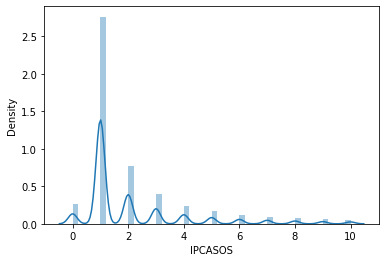

In [29]:
# Se trabajó con los percentiles 
df1=df[df.IPCASOS<=10]
sns.distplot(df1['IPCASOS']);

In [30]:
# Prueba de normalidad en los datos

# Prueba de Shapiro-Wilk
stat, p = shapiro(df1['IPCASOS'])
print('Estadisticos=%.3f, p=%.3f' % (stat, p))
# Interpretación
alpha = 0.05
if p >= alpha:
   print('IPCASOS siguen una distribución Normal (no se rechaza la hipótesis nula H0)')
else:
   print('IPCASOS no se distribuye normalmente (se rechaza la hipótesis nula H0)')

Estadisticos=0.698, p=0.000
IPCASOS no se distribuye normalmente (se rechaza la hipótesis nula H0)


In [31]:
# Variable DESC_FICHABASICA
print(df['DESC_FICHABASICA'].describe())

count    367452.000000
mean          1.011152
std           9.105816
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max        3206.000000
Name: DESC_FICHABASICA, dtype: float64


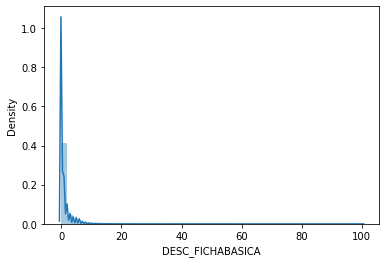

In [32]:
# Se trabajó con los percentiles o cuartiles 
df1=df[df.DESC_FICHABASICA<=100]
sns.distplot(df1['DESC_FICHABASICA']);

In [33]:
# Prueba de normalidad en DESC_FICHABÁSICA

# Prueba de Shapiro-Wilk
stat, p = shapiro(df1['DESC_FICHABASICA'])
print('Estadisticos=%.3f, p=%.3f' % (stat, p))
# Interpretación
alpha = 0.05
if p >= alpha:
   print('DESC_FICHABASICA siguen una distribución Normal (no se rechaza la hipótesis nula H0)')
else:
   print('DESC_FICHABASICA no se distribuye normalmente (se rechaza la hipótesis nula H0)')

Estadisticos=0.346, p=0.000
DESC_FICHABASICA no se distribuye normalmente (se rechaza la hipótesis nula H0)


In [34]:
# Variable DESC_PERFILPROMOCIONAL
print(df['DESC_PERFILPROMOCIONAL'].describe())
print(df.groupby('DESC_PERFILPROMOCIONAL').size()/len(df))

count    367452.000000
mean          1.153443
std           0.874738
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           5.000000
Name: DESC_PERFILPROMOCIONAL, dtype: float64
DESC_PERFILPROMOCIONAL
0    0.065875
1    0.852030
2    0.024455
3    0.013009
4    0.009680
5    0.034952
dtype: float64


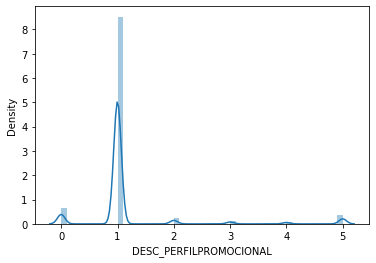

In [35]:
# Se trabajó con los percentiles o cuartiles
df1=df[df.DESC_PERFILPROMOCIONAL<=100]
sns.distplot(df1['DESC_PERFILPROMOCIONAL']);

In [36]:
# Prueba de normalidad en los DESC_PERFIL PROMOCIONAL

# Prueba de Shapiro-Wilk
stat, p = shapiro(df1['DESC_PERFILPROMOCIONAL'])
print('Estadisticos=%.3f, p=%.3f' % (stat, p))
# Interpretación
alpha = 0.05
if p >= alpha:
   print('DESC_PERFILPROMOCIONAL siguen una distribución Normal (no se rechaza la hipótesis nula H0)')
else:
   print('DESC_PERFILPROMOCIONAL no se distribuye normalmente(se rechaza la hipótesis nula H0)')

Estadisticos=0.420, p=0.000
DESC_PERFILPROMOCIONAL no se distribuye normalmente(se rechaza la hipótesis nula H0)


In [37]:
# Variable consumos totales
print(df['CONSUMOSTOTAL'].describe())
print(df.groupby('CONSUMOSTOTAL').size()/len(df))
print(df.groupby(['DESC_FICHABASICA','DESC_PERFILPROMOCIONAL']).size()/len(df))

count    367452.000000
mean          2.164596
std           9.275138
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        3207.000000
Name: CONSUMOSTOTAL, dtype: float64
CONSUMOSTOTAL
1       0.721523
2       0.116061
3       0.045783
4       0.026950
5       0.014369
          ...   
1085    0.000003
1660    0.000003
2062    0.000003
2343    0.000003
3207    0.000003
Length: 152, dtype: float64
DESC_FICHABASICA  DESC_PERFILPROMOCIONAL
0                 1                         0.680829
                  2                         0.000871
                  3                         0.000005
                  4                         0.000003
1                 0                         0.040694
                                              ...   
1085              0                         0.000003
1659              1                         0.000003
2062              0                         0.000003
2342              1              

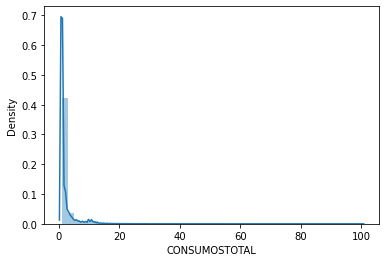

In [38]:
# Se trabajó con los percentiles o cuartiles
df1=df[df.CONSUMOSTOTAL<=100]
sns.distplot(df1['CONSUMOSTOTAL']);

In [39]:
# Variable Login
print(df['CANTIDADLOGIN'].describe())
print(df.groupby('CANTIDADLOGIN').size()/len(df))

count    367452.000000
mean          1.676110
std           4.843118
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max        1307.000000
Name: CANTIDADLOGIN, dtype: float64
CANTIDADLOGIN
0       0.463835
1       0.220655
2       0.111615
3       0.064542
4       0.040980
          ...   
437     0.000003
478     0.000003
481     0.000003
559     0.000003
1307    0.000003
Length: 159, dtype: float64


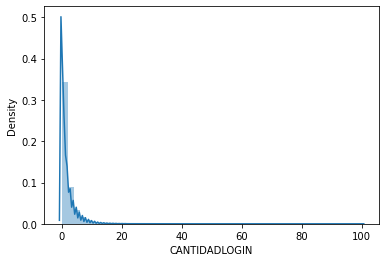

In [40]:
# Se trabajó con los percentiles o cuartiles
df1=df[df.CANTIDADLOGIN<=100]
sns.distplot(df1['CANTIDADLOGIN']);

In [41]:
# Prueba de normalidad en los cantidad login

# Prueba de Shapiro-Wilk
stat, p = shapiro(df1['CANTIDADLOGIN'])
print('Estadisticos=%.3f, p=%.3f' % (stat, p))
# Interpretación
alpha = 0.05
if p >= alpha:
   print('CANTIDADLOGIN siguen una distribución Normal (no se rechaza la hipótesis nula H0)')
else:
   print('CANTIDADLOGIN no se distribuye normalmente(se rechaza la hipótesis nula H0)')

Estadisticos=0.506, p=0.000
CANTIDADLOGIN no se distribuye normalmente(se rechaza la hipótesis nula H0)


In [42]:
# Variable promedio de sesiones
print(df['PROMEDIO_SESIONES'].describe())
print(df.groupby('PROMEDIO_SESIONES').size()/len(df))

count    367452.000000
mean          4.785507
std           5.787631
min           1.000000
25%           3.000000
50%           3.000000
75%           4.500000
max         552.000000
Name: PROMEDIO_SESIONES, dtype: float64
PROMEDIO_SESIONES
1.000000      0.000122
1.142857      0.000003
1.250000      0.000005
1.333333      0.000191
1.400000      0.000008
                ...   
339.000000    0.000003
382.500000    0.000003
392.000000    0.000003
425.000000    0.000003
552.000000    0.000003
Length: 476, dtype: float64


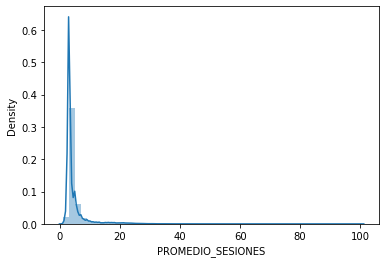

In [43]:
# Se trabajó con los percentiles o cuartiles
df1=df[df.PROMEDIO_SESIONES<=100]
sns.distplot(df1['PROMEDIO_SESIONES']);

In [44]:
# Prueba de normalidad en los cantidad login

# Prueba de Shapiro-Wilk
stat, p = shapiro(df1['PROMEDIO_SESIONES'])
print('Estadisticos=%.3f, p=%.3f' % (stat, p))
# Interpretación
alpha = 0.05
if p >= alpha:
   print('PROMEDIO_SESIONES siguen una distribución Normal (no se rechaza la hipótesis nula H0)')
else:
   print('PROMEDIO_SESIONES no se distribuye normalmente(se rechaza la hipótesis nula H0)')

Estadisticos=0.415, p=0.000
PROMEDIO_SESIONES no se distribuye normalmente(se rechaza la hipótesis nula H0)


In [45]:
##Variable tipo de usuario según el indicador del cliente
print(df.groupby('TIPOUSUARIO').size()/len(df))
df1 = df.loc[(df['IND_CLIENTE'] == 1), :]
print(df1.groupby('TIPOUSUARIO').size()/len(df1))

TIPOUSUARIO
PF    0.722881
PJ    0.244176
PX    0.032943
dtype: float64
TIPOUSUARIO
PF    0.439560
PJ    0.508030
PX    0.052409
dtype: float64


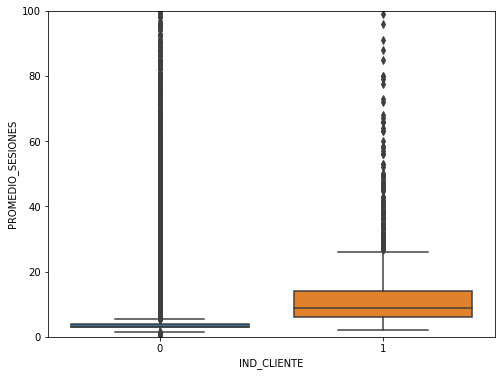

In [46]:
# Diagrama de cajas Ind_Cliente vs promedio sesiones:

var = 'IND_CLIENTE'
data = pd.concat([df['PROMEDIO_SESIONES'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="PROMEDIO_SESIONES", data=data)
fig.axis(ymin=0, ymax=100);

In [47]:
# Variable canal del registro según el indicador del cliente
print(df.groupby('CANAL_REGISTRO').size()/len(df))
df1 = df.loc[(df['IND_CLIENTE'] == 1), :]
print(df1.groupby('CANAL_REGISTRO').size()/len(df1))

CANAL_REGISTRO
1.0    0.099112
2.0    0.230180
3.0    0.323525
4.0    0.044471
6.0    0.033115
7.0    0.100974
8.0    0.129797
9.0    0.018332
dtype: float64
CANAL_REGISTRO
1.0    0.229079
2.0    0.139899
3.0    0.189772
4.0    0.110735
6.0    0.047337
7.0    0.194421
8.0    0.059594
9.0    0.021555
dtype: float64


In [48]:
# Variable Bondad email según el indicador del cliente
print(df.groupby('BONDAD_EMAIL').size()/len(df))
df1 = df.loc[(df['IND_CLIENTE'] == 1), :]
print(df1.groupby('BONDAD_EMAIL').size()/len(df1))

BONDAD_EMAIL
-20    0.032777
-10    0.045786
 0     0.147102
 1     0.013447
 9     0.013204
 20    0.747684
dtype: float64
BONDAD_EMAIL
-20    0.011834
-10    0.006762
 0     0.022401
 1     0.010144
 9     0.010144
 20    0.938715
dtype: float64


In [49]:
# Variable Tipo de empresa según el indicador del cliente
print(df.groupby('USU_TIPO').size()/len(df))
df1 = df.loc[(df['IND_CLIENTE'] == 1), :]
print(df1.groupby('USU_TIPO').size()/len(df1))

USU_TIPO
EMPRESARIO INDIVIDUAL              0.108539
ENTIDAD EXTRANJERA                 0.000746
ENTIDAD FINANCIERA O DE SEGUROS    0.006817
ENTIDAD SIN ANIMO DE LUCRO         0.006741
HOLDING                            0.001061
INDUSTRIA / COMERCIO               0.000005
ORGANISMO ESTATAL                  0.001881
SOCIEDAD COMERCIAL/INDUSTRIAL      0.102811
SOCIEDAD NO COMERCIAL              0.000035
dtype: float64
USU_TIPO
EMPRESARIO INDIVIDUAL              0.070583
ENTIDAD EXTRANJERA                 0.005917
ENTIDAD FINANCIERA O DE SEGUROS    0.016906
ENTIDAD SIN ANIMO DE LUCRO         0.010989
HOLDING                            0.004227
ORGANISMO ESTATAL                  0.000423
SOCIEDAD COMERCIAL/INDUSTRIAL      0.382502
dtype: float64


In [50]:
# Variable Tamaño de empresa según el indicador del cliente
print(df.groupby('USU_TAMANIO').size()/len(df))
df1 = df.loc[(df['IND_CLIENTE'] == 1), :]
print(df1.groupby('USU_TAMANIO').size()/len(df1))

USU_TAMANIO
GR    0.015825
MC    0.164841
MD    0.015594
PQ    0.027446
SD    0.004937
dtype: float64
USU_TAMANIO
GR    0.055790
MC    0.217244
MD    0.096365
PQ    0.119189
SD    0.002959
dtype: float64


In [51]:
# Variable estado de la empresa según el indicador del cliente
print(df.groupby('USU_ESTADO').size()/len(df))
df1 = df.loc[(df['IND_CLIENTE'] == 1), :]
print(df1.groupby('USU_ESTADO').size()/len(df1))

USU_ESTADO
ACTIVA                                              0.183673
ANULACIÓN LIQUIDACIÓN                               0.000014
CANCELACIÓN                                         0.035558
COINCIDENCIA HOMOGRAFA LISTA CLINTON (SDNT OFAC)    0.000024
EXTINGUIDA                                          0.000746
INACTIVA TEMPORAL                                   0.000710
INTERVENIDA                                         0.000024
LEY DE INSOLVENCIA (REORGANIZACION EMPRESARIAL)     0.001361
LIQUIDACION                                         0.006425
REESTRUCTURACION O CONCORDATO                       0.000087
SALIDA CLINTON (SDNT OFAC)                          0.000019
dtype: float64
USU_ESTADO
ACTIVA                                             0.448436
CANCELACIÓN                                        0.027895
EXTINGUIDA                                         0.000845
LEY DE INSOLVENCIA (REORGANIZACION EMPRESARIAL)    0.004649
LIQUIDACION                                        0

In [52]:
# Variable departamento de la empresa según el indicador del cliente
print(df.groupby('USU_DEPARTAMENTO').size()/len(df))
df1 = df.loc[(df['IND_CLIENTE'] == 1), :]
print(df1.groupby('USU_DEPARTAMENTO').size()/len(df1))

USU_DEPARTAMENTO
AMAZONAS           0.000185
ANTIOQUIA          0.030344
ARAUCA             0.000718
ATLANTICO          0.011648
BOGOTA             0.090507
BOLIVAR            0.005707
BOYACA             0.005900
CALDAS             0.003753
CAQUETA            0.001129
CASANARE           0.002656
CAUCA              0.003214
CESAR              0.003230
CHOCO              0.000610
CORDOBA            0.002474
CUNDINAMARCA       0.013411
GUAINIA            0.000003
GUAVIARE           0.000259
HUILA              0.004961
LA GUAJIRA         0.001674
MAGDALENA          0.003015
META               0.005024
NARINO             0.003998
NORTE SANTANDER    0.005454
PUTUMAYO           0.001061
QUINDIO            0.002066
RISARALDA          0.005666
SAN ANDRES         0.000376
SANTANDER          0.010578
SUCRE              0.001682
TOLIMA             0.004841
VALLE              0.019875
VAUPES             0.000003
VICHADA            0.000005
dtype: float64
USU_DEPARTAMENTO
ANTIOQUIA          0.084531

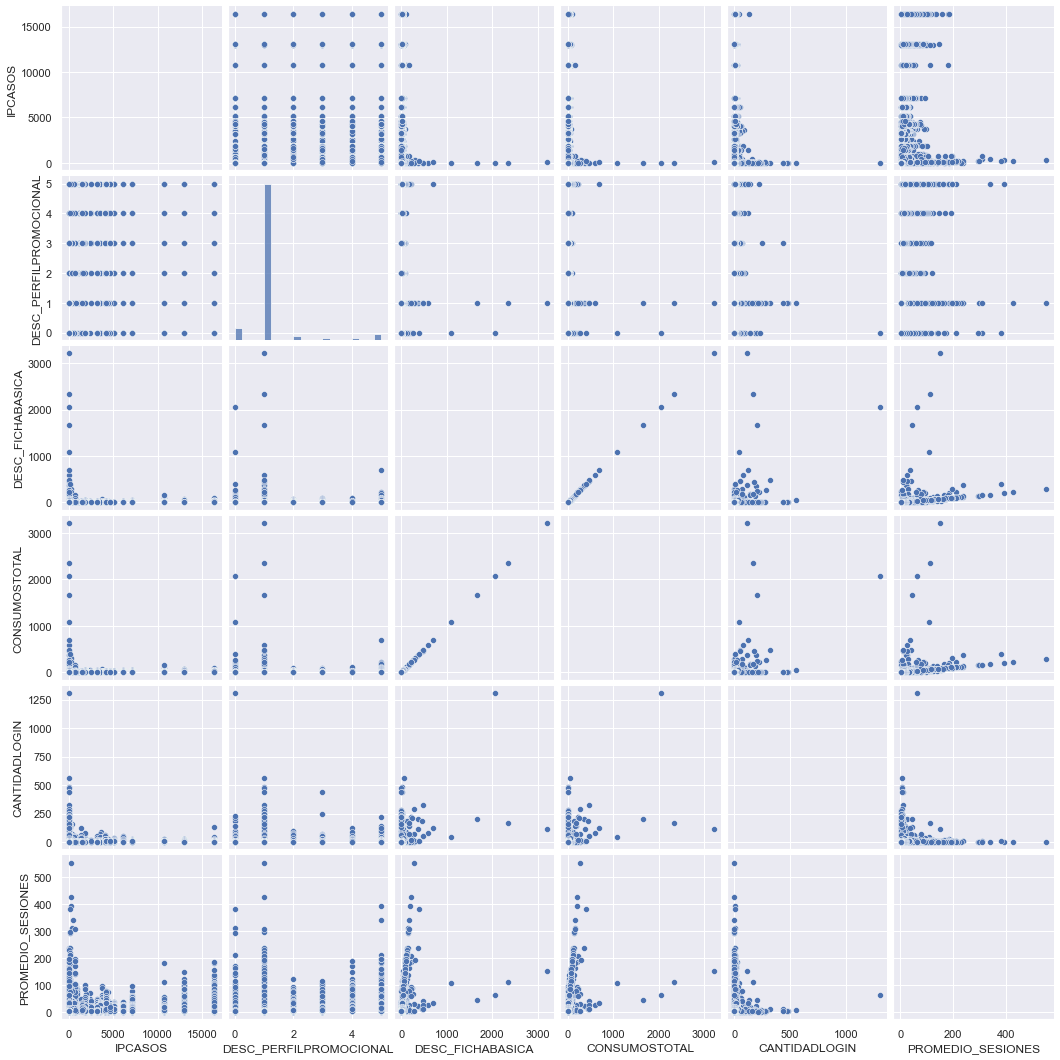

In [53]:
# Scatter plot
sns.set()
cols = ['IPCASOS', 'DESC_PERFILPROMOCIONAL', 'DESC_FICHABASICA', 'CONSUMOSTOTAL', 'CANTIDADLOGIN', 'PROMEDIO_SESIONES']
sns.pairplot(df[cols], size = 2.5)
plt.show();

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


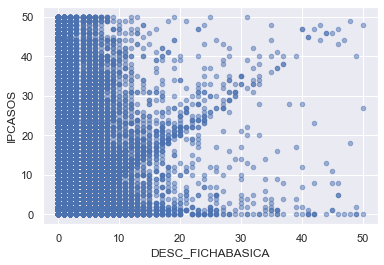

In [54]:
# Dispersión ipcasos vs ficha básica
var = 'DESC_FICHABASICA'
df1 = df.loc[(df['IPCASOS'] <= 50), :]
df2 = df.loc[(df['DESC_FICHABASICA'] <= 50), :]
data = pd.concat([df1['IPCASOS'], df2[var]], axis=1)
data.plot.scatter(x=var, y='IPCASOS', alpha = 0.5);

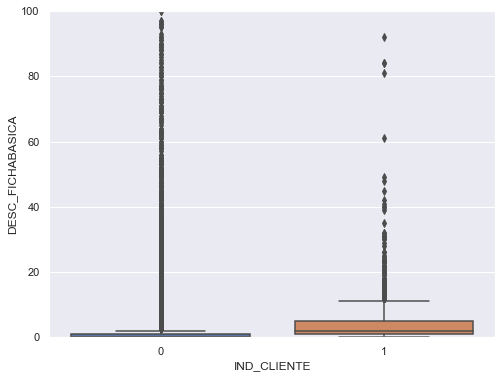

In [55]:
# Diagrama de cajas ind_cliente vs DESC_FICHABASICA:

var = 'IND_CLIENTE'
data = pd.concat([df['DESC_FICHABASICA'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="DESC_FICHABASICA", data=data)
fig.axis(ymin=0, ymax=100);

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


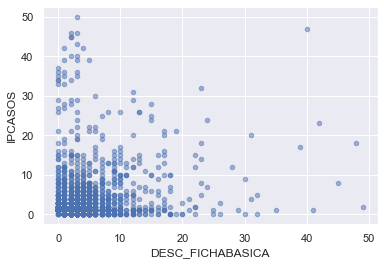

In [56]:
# Dispersión ipcasos vs DESC_FICHABASICA (Clientes potenciales)
var = 'DESC_FICHABASICA'
dfind = df.loc[(df['IND_CLIENTE'] == 1), :]
df1 = dfind.loc[(dfind['IPCASOS'] <= 50), :]
df2 = dfind.loc[(dfind['DESC_FICHABASICA'] <= 50), :]
data = pd.concat([df1['IPCASOS'], df2[var]], axis=1)
data.plot.scatter(x=var, y='IPCASOS', alpha = 0.5);

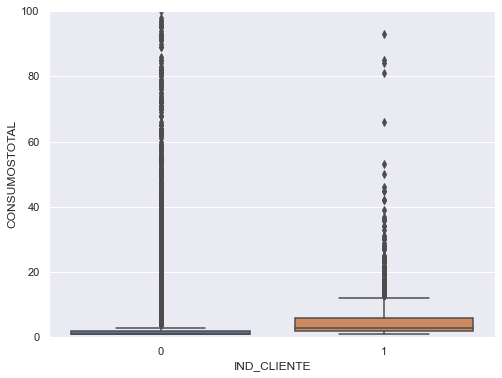

In [57]:
# Diagrama de cajas ind_cliente vs CONSUMOSTOTAL:

var = 'IND_CLIENTE'
data = pd.concat([df['CONSUMOSTOTAL'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="CONSUMOSTOTAL", data=data)
fig.axis(ymin=0, ymax=100);

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


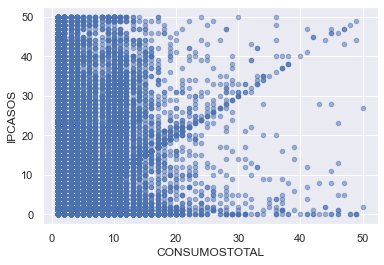

In [58]:
# Dispersión ipcasos vs CONSUMOSTOTAL
var = 'CONSUMOSTOTAL'
df1 = df.loc[(df['IPCASOS'] <= 50), :]
df2 = df.loc[(df['CONSUMOSTOTAL'] <= 50), :]
data = pd.concat([df1['IPCASOS'], df2[var]], axis=1)
data.plot.scatter(x=var, y='IPCASOS', alpha = 0.5);

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


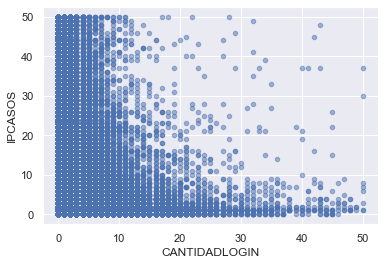

In [59]:
# Dispersión ipcasos vs CANTIDADLOGIN
var = 'CANTIDADLOGIN'
df1 = df.loc[(df['IPCASOS'] <= 50), :]
df2 = df.loc[(df['CANTIDADLOGIN'] <= 50), :]
data = pd.concat([df1['IPCASOS'], df2[var]], axis=1)
data.plot.scatter(x=var, y='IPCASOS', alpha = 0.5);

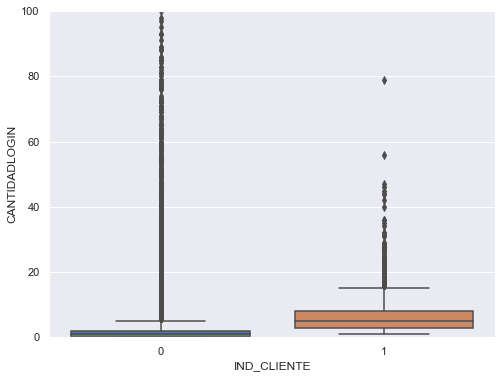

In [60]:
# Diagrama de cajas ind_cliente vs CANTIDADLOGIN:

var = 'IND_CLIENTE'
data = pd.concat([df['CANTIDADLOGIN'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="CANTIDADLOGIN", data=data)
fig.axis(ymin=0, ymax=100);

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


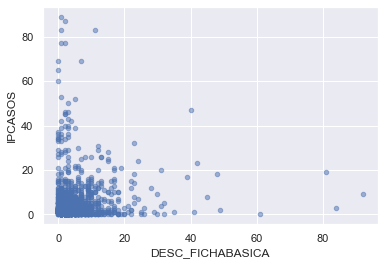

In [61]:
# Dispersión IPCASOS vs DESC_FICHABASICA (Clientes potenciales)
var = 'DESC_FICHABASICA'
dfind = df.loc[(df['IND_CLIENTE'] == 1), :]
df1 = dfind.loc[(dfind['IPCASOS'] <= 100), :]
df2 = dfind.loc[(dfind['DESC_FICHABASICA'] <= 100), :]
data = pd.concat([df1['IPCASOS'], df2[var]], axis=1)
data.plot.scatter(x=var, y='IPCASOS', alpha = 0.5);

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


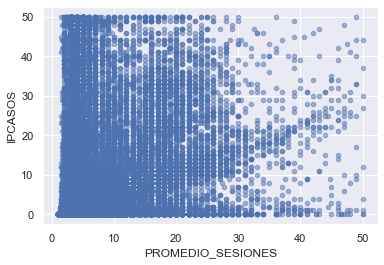

In [62]:
# Dispersión IPCASOS vs PROMEDIO_SESIONES
var = 'PROMEDIO_SESIONES'
df1 = df.loc[(df['IPCASOS'] <= 50), :]
df2 = df.loc[(df['PROMEDIO_SESIONES'] <= 50), :]
data = pd.concat([df1['IPCASOS'], df2[var]], axis=1)
data.plot.scatter(x=var, y='IPCASOS', alpha = 0.5);

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


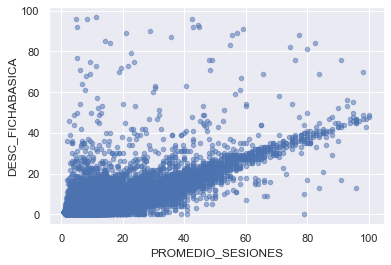

In [63]:
# Dispersión DESC_FICHABASICA vs PROMEDIO_SESIONES
var = 'PROMEDIO_SESIONES'
df1 = df.loc[(df['DESC_FICHABASICA'] <= 100), :]
df2 = df.loc[(df['PROMEDIO_SESIONES'] <= 100), :]
data = pd.concat([df1['DESC_FICHABASICA'], df2[var]], axis=1)
data.plot.scatter(x=var, y='DESC_FICHABASICA', alpha = 0.5);

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


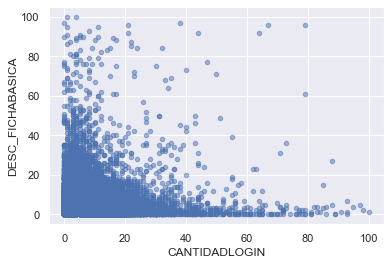

In [64]:
# Dispersión CANTIDADLOGIN vs DESC_FICHABASICA
var = 'CANTIDADLOGIN'
df1 = df.loc[(df['DESC_FICHABASICA'] <= 100), :]
df2 = df.loc[(df['CANTIDADLOGIN'] <= 100), :]
data = pd.concat([df1['DESC_FICHABASICA'], df2[var]], axis=1)
data.plot.scatter(x=var, y='DESC_FICHABASICA', alpha = 0.5);

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


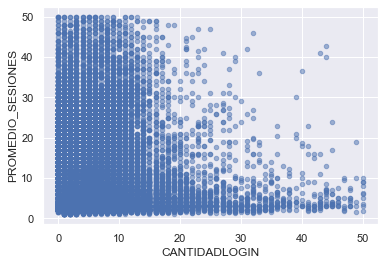

In [65]:
#Dispersión CANTIDADLOGIN vs PROMEDIO_SESIONES
var = 'CANTIDADLOGIN'
df1 = df.loc[(df['PROMEDIO_SESIONES'] <= 50), :]
df2 = df.loc[(df['CANTIDADLOGIN'] <= 50), :]
data = pd.concat([df1['PROMEDIO_SESIONES'], df2[var]], axis=1)
data.plot.scatter(x=var, y='PROMEDIO_SESIONES', alpha = 0.5);

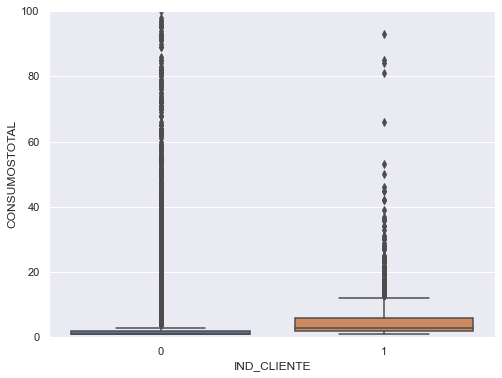

In [66]:
# Diagrama de cajas ind_cliente vs CONSUMOSTOTALES:

var = 'IND_CLIENTE'
data = pd.concat([df['CONSUMOSTOTAL'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="CONSUMOSTOTAL", data=data)
fig.axis(ymin=0, ymax=100);

## Análisis descriptivo del dataframe

In [67]:
# Mostrar numero de columnas y filas del dataframe final()
rows, cols = df.shape
print('No. de Filas:', rows)
print('No. de Columnas:', cols)

No. de Filas: 367452
No. de Columnas: 16


In [68]:
# Mostrando el porcentaje de las filas con valores nulos por cada columna
a = df.isnull().sum()/len(df)*100

print('Los porcentajes de valores faltantes son: \n', a)


Los porcentajes de valores faltantes son: 
 IDUSUARIO                  0.000000
TIPOUSUARIO                0.000000
CANAL_REGISTRO             2.049519
IND_CLIENTE                0.000000
BONDAD_EMAIL               0.000000
IPCASOS                    0.000000
USU_TIPO                  77.136333
USU_TAMANIO               77.135789
USU_CIIU                  77.135789
USU_ESTADO                77.135789
USU_DEPARTAMENTO          75.397331
DESC_FICHABASICA           0.000000
DESC_PERFILPROMOCIONAL     0.000000
CONSUMOSTOTAL              0.000000
CANTIDADLOGIN              0.000000
PROMEDIO_SESIONES          0.000000
dtype: float64


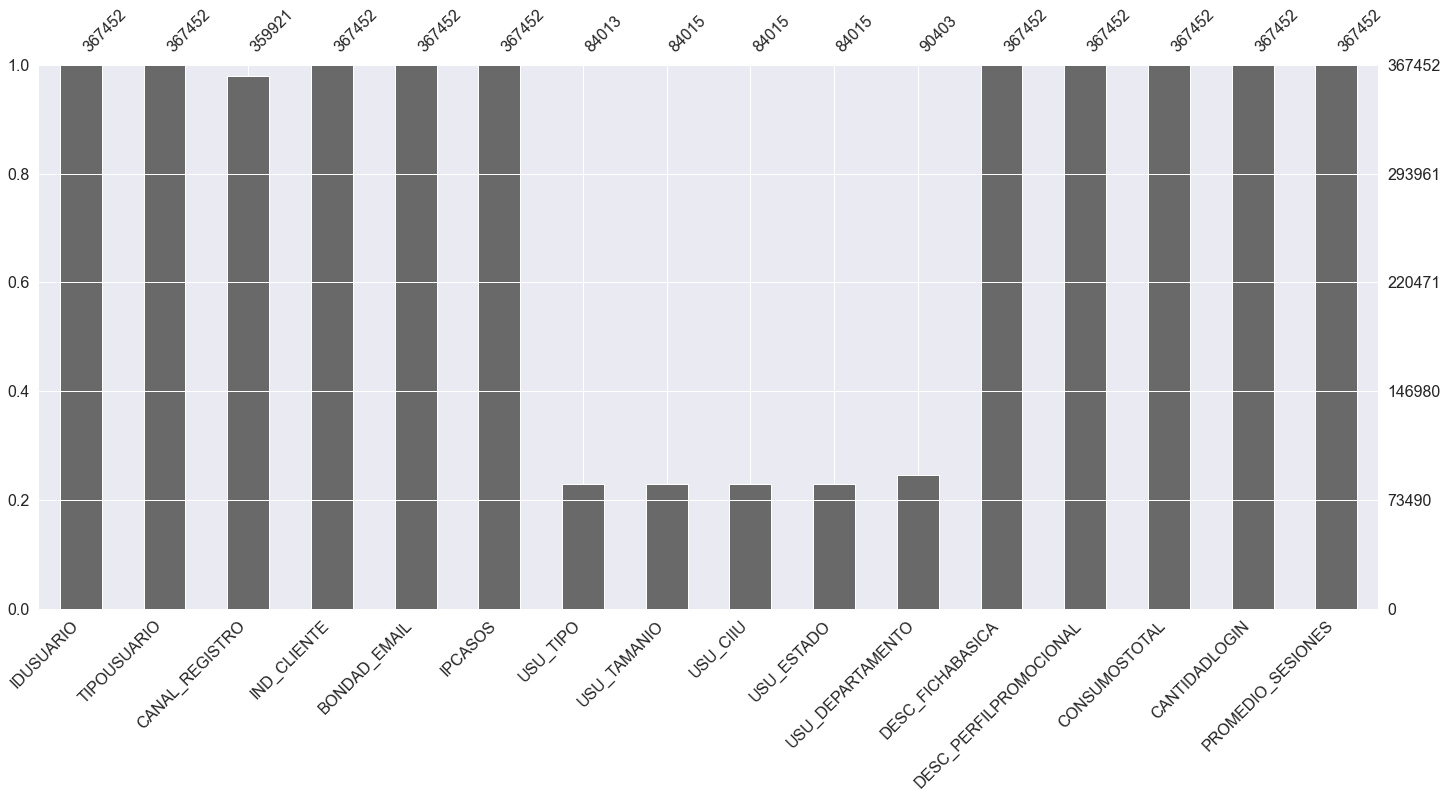

In [69]:
# Graficando la info de los valores faltantes
msno.bar(df);

In [70]:
# Se eliminan las columnas que tienen el 70% o más de valores faltantes
limitPer = len(df) * .70
sub_df = df.dropna(thresh=limitPer, axis=1)

In [71]:
# Mostrar los primeros 5 registros de la tabla resultante del filtro de valores faltantes
sub_df.head()

,IDUSUARIO,TIPOUSUARIO,CANAL_REGISTRO,IND_CLIENTE,BONDAD_EMAIL,IPCASOS,DESC_FICHABASICA,DESC_PERFILPROMOCIONAL,CONSUMOSTOTAL,CANTIDADLOGIN,PROMEDIO_SESIONES
0,"6869752,00",PJ,3.0,1,20,1,4,0,4,17,13.50
1,"6869802,00",PJ,1.0,1,20,3,2,0,2,8,3.00
2,"6870488,00",PF,1.0,1,20,8,8,1,9,15,5.25
3,"6870818,00",PF,2.0,1,20,1,2,1,3,8,5.50
4,"6871584,00",PJ,6.0,1,20,1,1,1,2,9,3.00


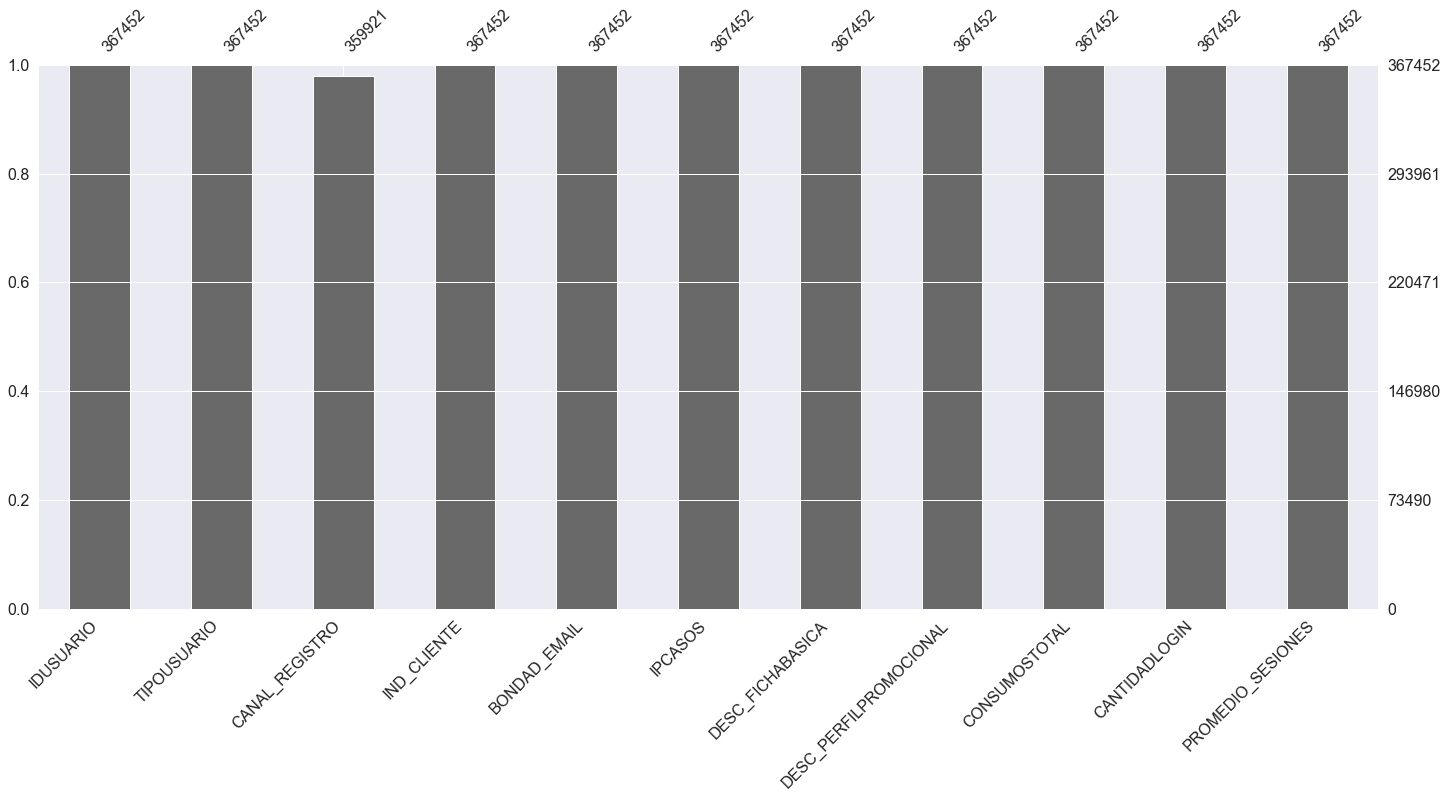

In [72]:
# Graficando la info de los valores faltantes otra vez
msno.bar(sub_df);

In [73]:
# Eliminar filas con valores nulos
sub_df = sub_df.dropna()
# Mostrar numero de filas y columnas resultantes del filtro
sub_df.shape

(359921, 11)

In [74]:
# Mostrar tabla resultante del filtro
sub_df

,IDUSUARIO,TIPOUSUARIO,CANAL_REGISTRO,IND_CLIENTE,BONDAD_EMAIL,IPCASOS,DESC_FICHABASICA,DESC_PERFILPROMOCIONAL,CONSUMOSTOTAL,CANTIDADLOGIN,PROMEDIO_SESIONES
0,"6869752,00",PJ,3.0,1,20,1,4,0,4,17,13.50
1,"6869802,00",PJ,1.0,1,20,3,2,0,2,8,3.00
2,"6870488,00",PF,1.0,1,20,8,8,1,9,15,5.25
3,"6870818,00",PF,2.0,1,20,1,2,1,3,8,5.50
4,"6871584,00",PJ,6.0,1,20,1,1,1,2,9,3.00
...,...,...,...,...,...,...,...,...,...,...,...
367447,"8250344,00",PF,9.0,0,20,1,0,1,1,0,3.00
367448,"8250350,00",PJ,2.0,0,20,1,0,1,1,0,3.00
367449,"8250356,00",PF,2.0,0,0,1,0,1,1,0,3.00
367450,"8250359,00",PF,8.0,0,20,1,0,1,1,0,3.00


In [75]:
# Resumen estadistico por cada columna numerica
sub_df.describe()

,CANAL_REGISTRO,IND_CLIENTE,BONDAD_EMAIL,IPCASOS,DESC_FICHABASICA,DESC_PERFILPROMOCIONAL,CONSUMOSTOTAL,CANTIDADLOGIN,PROMEDIO_SESIONES
count,359921.000000,359921.000000,359921.000000,359921.000000,359921.000000,359921.000000,359921.000000,359921.000000,359921.000000
mean,3.896655,0.006524,14.143026,355.086850,0.998394,1.140609,2.139003,1.690804,4.736873
std,2.412753,0.080505,10.967848,1707.170272,9.186513,0.851006,9.346465,4.878985,5.713973
min,1.000000,0.000000,-20.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
25%,2.000000,0.000000,20.000000,1.000000,0.000000,1.000000,1.000000,0.000000,3.000000
50%,3.000000,0.000000,20.000000,2.000000,0.000000,1.000000,1.000000,1.000000,3.000000
75%,7.000000,0.000000,20.000000,5.000000,1.000000,1.000000,2.000000,2.000000,4.000000
max,9.000000,1.000000,20.000000,16393.000000,3206.000000,5.000000,3207.000000,1307.000000,552.000000


### Tratatamiento de Valores Extremos

count    359921.000000
mean        355.086850
std        1707.170272
min           0.000000
25%           1.000000
50%           2.000000
75%           5.000000
max       16393.000000
Name: IPCASOS, dtype: float64
count    350257.000000
mean        108.393411
std         530.348017
min           0.000000
25%           1.000000
50%           1.000000
75%           5.000000
max        4260.000000
Name: IPCASOS, dtype: float64


{'whiskers': [<matplotlib.lines.Line2D at 0x1fd60ebba60>,
 'caps': [<matplotlib.lines.Line2D at 0x1fd60ec80a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fd60ebb6d0>],
 'medians': [<matplotlib.lines.Line2D at 0x1fd60ec87c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1fd60ec8b50>],
 'means': []}

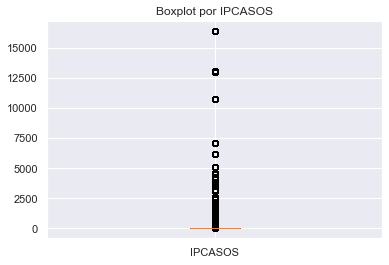

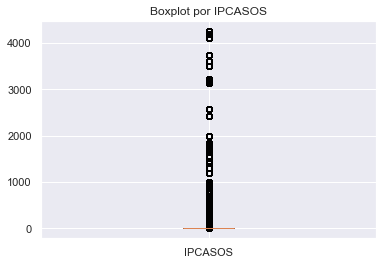

In [76]:
# Descripción de la data
# IPCASOS
# Crear canvas para aplicar figura
fig, ax = plt.subplots()
# Colocar titulo a la grafica
ax.set_title('Boxplot por IPCASOS')
# Box plot por IPCASOS
ax.boxplot(sub_df['IPCASOS'], labels=["IPCASOS"])

# Mostrar descripcion estadistica de la columna IPCASOS
print(sub_df['IPCASOS'].describe())
# Eliminacion de registros que su valor absoluto (Para la columna IPCASOS) tiene -5 desviaciones estandar
sub_df = sub_df[np.abs(sub_df.IPCASOS - sub_df.IPCASOS.mean()) < (5*sub_df.IPCASOS.std())]
# Eliminacion de registros que su valor absoluto (Para la columna IPCASOS) tiene +5 desviaciones estandar
sub_df = sub_df[~(np.abs(sub_df.IPCASOS - sub_df.IPCASOS.mean()) > (5*sub_df.IPCASOS.std()))]
# Mostrar descripcion estadistica de la columna IPCASOS
print(sub_df['IPCASOS'].describe())
# Crear canvas para aplicar figura
fig, ax = plt.subplots()
# Colocar titulo a la grafica
ax.set_title('Boxplot por IPCASOS')
ax.boxplot(sub_df['IPCASOS'], labels=["IPCASOS"])

count    350257.000000
mean          0.868431
std           9.206820
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max        3206.000000
Name: DESC_FICHABASICA, dtype: float64
count    347847.000000
mean          0.675797
std           1.459684
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          10.000000
Name: DESC_FICHABASICA, dtype: float64


{'whiskers': [<matplotlib.lines.Line2D at 0x1fd6a09c340>,
 'caps': [<matplotlib.lines.Line2D at 0x1fd6a09ca60>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fd6a08bf70>],
 'medians': [<matplotlib.lines.Line2D at 0x1fd6a0a51c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1fd6a0a5550>],
 'means': []}

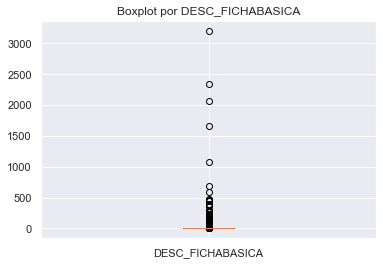

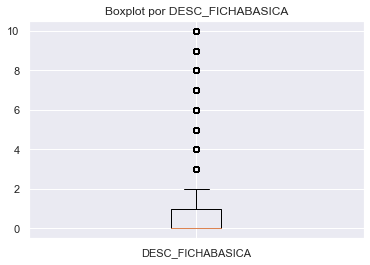

In [77]:
##DESC_FICHABASICA
# Crear canvas para aplicar figura
fig, ax = plt.subplots()
# Colocar titulo a la grafica
ax.set_title('Boxplot por DESC_FICHABASICA')
# Box plot por DESC_FICHABASICA
ax.boxplot(sub_df['DESC_FICHABASICA'], labels=["DESC_FICHABASICA"])
# Mostrar descripcion estadistica de la columna DESC_FICHABASICA
print(sub_df['DESC_FICHABASICA'].describe())
# Eliminacion de registros que su valor absoluto (Para la columna DESC_FICHABASICA) tiene -5 desviaciones estandar
sub_df = sub_df[np.abs(sub_df.DESC_FICHABASICA - sub_df.DESC_FICHABASICA.mean()) < (5*sub_df.DESC_FICHABASICA.std())]
# Eliminacion de registros que su valor absoluto (Para la columna DESC_FICHABASICA) tiene +5 desviaciones estandar
sub_df = sub_df[~(np.abs(sub_df.DESC_FICHABASICA - sub_df.DESC_FICHABASICA.mean()) > (5*sub_df.DESC_FICHABASICA.std()))]
# Mostrar descripcion estadistica de la columna DESC_FICHABASICA
print(sub_df['DESC_FICHABASICA'].describe())
# Crear canvas para aplicar figura
fig, ax = plt.subplots()
# Colocar titulo a la grafica
ax.set_title('Boxplot por DESC_FICHABASICA')
# Box plot por DESC_FICHABASICA
ax.boxplot(sub_df['DESC_FICHABASICA'], labels=["DESC_FICHABASICA"])

count    347847.000000
mean          1.077911
std           0.722635
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           5.000000
Name: DESC_PERFILPROMOCIONAL, dtype: float64


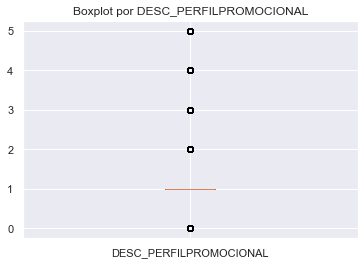

In [78]:
##DESC_PERFILPROMOCIONAL
# Crear canvas para aplicar figura
fig, ax = plt.subplots()
# Colocar titulo a la grafica
ax.set_title('Boxplot por DESC_PERFILPROMOCIONAL')
# Box plot por DESC_PERFILPROMOCIONAL
ax.boxplot(sub_df['DESC_PERFILPROMOCIONAL'], labels=["DESC_PERFILPROMOCIONAL"])
# Mostrar descripcion estadistica de la columna DESC_PERFILPROMOCIONAL
print(sub_df['DESC_PERFILPROMOCIONAL'].describe())

count    347847.000000
mean          1.753708
std           1.943417
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          15.000000
Name: CONSUMOSTOTAL, dtype: float64


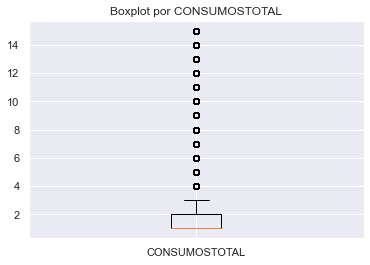

In [79]:
##CONSUMOSTOTAL
# Crear canvas para aplicar figura
fig, ax = plt.subplots()
# Colocar titulo a la grafica
ax.set_title('Boxplot por CONSUMOSTOTAL')
# Box plot por CONSUMOSTOTAL
ax.boxplot(sub_df['CONSUMOSTOTAL'], labels=["CONSUMOSTOTAL"])
# Mostrar descripcion estadistica de la columna CONSUMOSTOTAL
print(sub_df['CONSUMOSTOTAL'].describe())

count    347847.000000
mean          1.559082
std           3.923679
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max         481.000000
Name: CANTIDADLOGIN, dtype: float64
count    344983.000000
mean          1.364235
std           2.081782
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          13.000000
Name: CANTIDADLOGIN, dtype: float64


{'whiskers': [<matplotlib.lines.Line2D at 0x1fe2330ee80>,
 'caps': [<matplotlib.lines.Line2D at 0x1fe328505e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fe2330eaf0>],
 'medians': [<matplotlib.lines.Line2D at 0x1fe32850d00>],
 'fliers': [<matplotlib.lines.Line2D at 0x1fe3285d0d0>],
 'means': []}

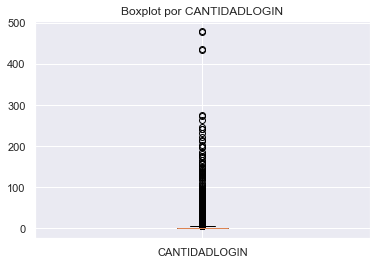

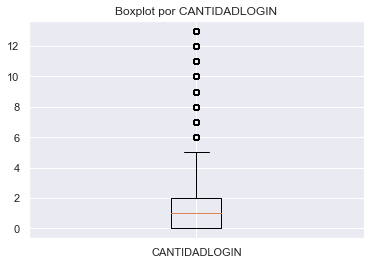

In [80]:
##CANTIDADLOGIN
# Crear canvas para aplicar figura
fig, ax = plt.subplots()
# Colocar titulo a la grafica
ax.set_title('Boxplot por CANTIDADLOGIN')
# Box plot por CANTIDADLOGIN
ax.boxplot(sub_df['CANTIDADLOGIN'], labels=["CANTIDADLOGIN"])
# Mostrar descripcion estadistica de la columna CANTIDADLOGIN
print(sub_df['CANTIDADLOGIN'].describe())
# Eliminacion de registros que su valor absoluto (Para la columna CANTIDADLOGIN) tiene -5 desviaciones estandar
sub_df = sub_df[np.abs(sub_df.CANTIDADLOGIN - sub_df.CANTIDADLOGIN.mean()) < (5*sub_df.CANTIDADLOGIN.std())]
# Eliminacion de registros que su valor absoluto (Para la columna CANTIDADLOGIN) tiene -5 desviaciones estandar
sub_df = sub_df[~(np.abs(sub_df.CANTIDADLOGIN - sub_df.CANTIDADLOGIN.mean()) > (5*sub_df.CANTIDADLOGIN.std()))]
# Mostrar descripcion estadistica de la columna CANTIDADLOGIN
print(sub_df['CANTIDADLOGIN'].describe())

# Crear canvas para aplicar figura
fig, ax = plt.subplots()
# Colocar titulo a la grafica
ax.set_title('Boxplot por CANTIDADLOGIN')
# Box plot por CANTIDADLOGIN
ax.boxplot(sub_df['CANTIDADLOGIN'], labels=["CANTIDADLOGIN"])

count    344983.000000
mean          4.223056
std           3.260555
min           1.000000
25%           3.000000
50%           3.000000
75%           4.000000
max          67.000000
Name: PROMEDIO_SESIONES, dtype: float64
count    337830.000000
mean          3.854925
std           1.985727
min           1.000000
25%           3.000000
50%           3.000000
75%           4.000000
max          16.000000
Name: PROMEDIO_SESIONES, dtype: float64


{'whiskers': [<matplotlib.lines.Line2D at 0x1fe3c34d160>,
 'caps': [<matplotlib.lines.Line2D at 0x1fe3c34d880>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fe3c33dd90>],
 'medians': [<matplotlib.lines.Line2D at 0x1fe3c34dfa0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1fe3c356370>],
 'means': []}

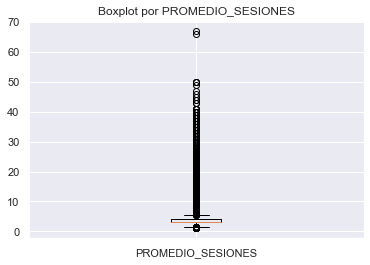

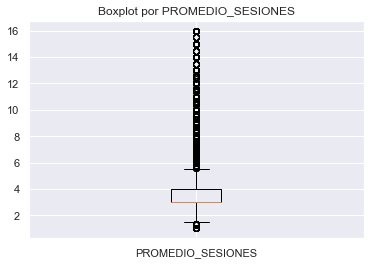

In [81]:
##PROMEDIO_SESIONES
# Crear canvas para aplicar figura
fig, ax = plt.subplots()
# Colocar titulo a la grafica
ax.set_title('Boxplot por PROMEDIO_SESIONES')
# Box plot por PROMEDIO_SESIONES
ax.boxplot(sub_df['PROMEDIO_SESIONES'], labels=["PROMEDIO_SESIONES"])
# Mostrar descripcion estadistica de la columna PROMEDIO_SESIONES
print(sub_df['PROMEDIO_SESIONES'].describe())
# Eliminacion de registros que su valor absoluto (Para la columna PROMEDIO_SESIONES) tiene -5 desviaciones estandar
sub_df = sub_df[np.abs(sub_df.PROMEDIO_SESIONES - sub_df.PROMEDIO_SESIONES.mean()) < (5*sub_df.PROMEDIO_SESIONES.std())]
# Eliminacion de registros que su valor absoluto (Para la columna PROMEDIO_SESIONES) tiene +5 desviaciones estandar
sub_df = sub_df[~(np.abs(sub_df.PROMEDIO_SESIONES - sub_df.PROMEDIO_SESIONES.mean()) > (5*sub_df.PROMEDIO_SESIONES.std()))]
# Mostrar descripcion estadistica de la columna PROMEDIO_SESIONES
print(sub_df['PROMEDIO_SESIONES'].describe())

# Crear canvas para aplicar figura
fig, ax = plt.subplots()
# Colocar titulo a la grafica
ax.set_title('Boxplot por PROMEDIO_SESIONES')
# Box plot por PROMEDIO_SESIONES
ax.boxplot(sub_df['PROMEDIO_SESIONES'], labels=["PROMEDIO_SESIONES"])

In [82]:
# Resumen estadistico para el dataframe resultante
sub_df.describe()

,CANAL_REGISTRO,IND_CLIENTE,BONDAD_EMAIL,IPCASOS,DESC_FICHABASICA,DESC_PERFILPROMOCIONAL,CONSUMOSTOTAL,CANTIDADLOGIN,PROMEDIO_SESIONES
count,337830.000000,337830.000000,337830.000000,337830.000000,337830.000000,337830.000000,337830.000000,337830.000000,337830.000000
mean,3.995927,0.005097,14.747645,84.074404,0.546852,1.005473,1.552325,1.310612,3.854925
std,2.404884,0.071213,10.623808,450.636398,1.185567,0.507281,1.416256,2.025015,1.985727
min,1.000000,0.000000,-20.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
25%,2.000000,0.000000,20.000000,1.000000,0.000000,1.000000,1.000000,0.000000,3.000000
50%,3.000000,0.000000,20.000000,1.000000,0.000000,1.000000,1.000000,1.000000,3.000000
75%,7.000000,0.000000,20.000000,4.000000,1.000000,1.000000,1.000000,2.000000,4.000000
max,9.000000,1.000000,20.000000,4260.000000,10.000000,5.000000,15.000000,13.000000,16.000000


In [83]:
# Mostrar primeros registros del dataframe
sub_df



,IDUSUARIO,TIPOUSUARIO,CANAL_REGISTRO,IND_CLIENTE,BONDAD_EMAIL,IPCASOS,DESC_FICHABASICA,DESC_PERFILPROMOCIONAL,CONSUMOSTOTAL,CANTIDADLOGIN,PROMEDIO_SESIONES
1,"6869802,00",PJ,1.0,1,20,3,2,0,2,8,3.0
3,"6870818,00",PF,2.0,1,20,1,2,1,3,8,5.5
4,"6871584,00",PJ,6.0,1,20,1,1,1,2,9,3.0
5,"6872102,00",PJ,1.0,1,20,5,3,1,4,3,4.0
8,"6873020,00",PJ,4.0,1,20,4,2,1,3,3,3.5
...,...,...,...,...,...,...,...,...,...,...,...
367447,"8250344,00",PF,9.0,0,20,1,0,1,1,0,3.0
367448,"8250350,00",PJ,2.0,0,20,1,0,1,1,0,3.0
367449,"8250356,00",PF,2.0,0,0,1,0,1,1,0,3.0
367450,"8250359,00",PF,8.0,0,20,1,0,1,1,0,3.0


In [84]:
# Reemplazar valores de PF, PJ, y PX por valores numericos representativos
sub_df.loc[sub_df['TIPOUSUARIO'] == 'PF',  ['TIPOUSUARIO']] = 1
sub_df.loc[sub_df['TIPOUSUARIO'] == 'PJ',  ['TIPOUSUARIO']] = 2
sub_df.loc[sub_df['TIPOUSUARIO'] == 'PX',  ['TIPOUSUARIO']] = 3

# Crear dataframe X sin columnas de IDUSUARIO e IND_CLIENTE
X = sub_df.drop(['IDUSUARIO', 'IND_CLIENTE'], axis=1)
# Crear dataframe Y solo con los valores de IND_CLIENTE
y = sub_df['IND_CLIENTE']


In [85]:
# Convertir columna CANAL_REGISTRO a tipo category
sub_df['CANAL_REGISTRO'] = sub_df['CANAL_REGISTRO'].astype('category')
# Convertir columna TIPOUSUARIO a tipo category
sub_df['TIPOUSUARIO'] = sub_df['TIPOUSUARIO'].astype('category')
# Convertir columna BONDAD_EMAIL a tipo category
sub_df['BONDAD_EMAIL'] = sub_df['BONDAD_EMAIL'].astype('category')


### Estudio de Colinealidad

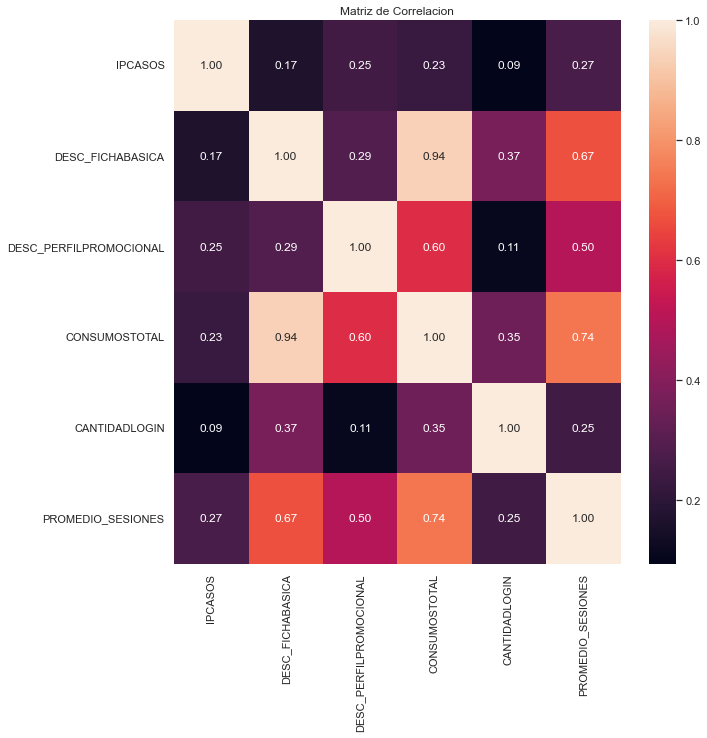

In [86]:
# Crear canvas para crear figura
plt.figure(figsize=(10, 10))
# Crear matriz de correlación entre las columnas ['IDUSUARIO', 'IND_CLIENTE', 'BONDAD_EMAIL', 'CANAL_REGISTRO', 'TIPOUSUARIO']
sns.heatmap(sub_df.drop(['IDUSUARIO', 'IND_CLIENTE', 'BONDAD_EMAIL', 'CANAL_REGISTRO', 'TIPOUSUARIO'], axis=1).corr(), annot=True, fmt='.2f')
# Agregar titulo a la grafica
plt.title('Matriz de Correlacion')
# Mostrar resultadod e la grafica
plt.show()

In [87]:
# Existe correlación entre las variables de CONSUMOTOTAL y DESC_FICHABASICA pues la primera es el resultado de una suma con la segunda
# Debido a esta dependencia se decirió no eliminar ninguna de estas 2 variables.
# Respecto a las otras no se encontró colinealidad

In [88]:
# Restablecer indices del dataframe
sub_df.reset_index(inplace=True, drop=True)

In [89]:
sub_df

,IDUSUARIO,TIPOUSUARIO,CANAL_REGISTRO,IND_CLIENTE,BONDAD_EMAIL,IPCASOS,DESC_FICHABASICA,DESC_PERFILPROMOCIONAL,CONSUMOSTOTAL,CANTIDADLOGIN,PROMEDIO_SESIONES
0,"6869802,00",2,1.0,1,20,3,2,0,2,8,3.0
1,"6870818,00",1,2.0,1,20,1,2,1,3,8,5.5
2,"6871584,00",2,6.0,1,20,1,1,1,2,9,3.0
3,"6872102,00",2,1.0,1,20,5,3,1,4,3,4.0
4,"6873020,00",2,4.0,1,20,4,2,1,3,3,3.5
...,...,...,...,...,...,...,...,...,...,...,...
337825,"8250344,00",1,9.0,0,20,1,0,1,1,0,3.0
337826,"8250350,00",2,2.0,0,20,1,0,1,1,0,3.0
337827,"8250356,00",1,2.0,0,0,1,0,1,1,0,3.0
337828,"8250359,00",1,8.0,0,20,1,0,1,1,0,3.0


### PCA

In [90]:
##Crear data con variables continuas para pca
sub_df_continuas = sub_df[['IPCASOS','DESC_FICHABASICA','DESC_PERFILPROMOCIONAL','CONSUMOSTOTAL','CANTIDADLOGIN','PROMEDIO_SESIONES']]
##Crear data con variables categoricas
sub_df_categoricas = sub_df[['IDUSUARIO','TIPOUSUARIO','CANAL_REGISTRO','IND_CLIENTE','BONDAD_EMAIL']]

In [91]:
# Estandarizar valores de las columnas continuas
X_scaled = StandardScaler().fit_transform(sub_df_continuas)
# Bajo pruebas anteriores se decidió crear 4 componentes principales que mejor representan los datos
# Crear instancia de PCA para realizar el calculo
pca = PCA(n_components=4)
# Realizar PCA a los valores estandarizados
pca_principal = pca.fit_transform(X_scaled)
# Crear dataframe con los valores de cada componente
pca_df = pd.DataFrame(data = pca_principal,
                      columns = ['PC1','PC2','PC3','PC4'])


In [92]:
# Mostrar valores de los componentes
pca_df

,PC1,PC2,PC3,PC4
0,0.649045,-3.218608,2.393756,0.318489
1,2.344678,-2.334224,1.559222,-0.854870
2,1.073555,-2.405227,2.253285,-1.676334
3,2.156667,-1.307849,-0.081079,0.622631
4,1.240065,-1.029772,0.150662,0.164556
...,...,...,...,...
337825,-0.849072,0.369152,-0.361459,-0.027919
337826,-0.849072,0.369152,-0.361459,-0.027919
337827,-0.849072,0.369152,-0.361459,-0.027919
337828,-0.849072,0.369152,-0.361459,-0.027919


In [93]:
# Varianza explicada con los 4 componentes
pca.explained_variance_ratio_.sum()

0.9433063237966195

In [94]:
# Suma acumulada de la varianza explicada por componente
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
var

array([52.6, 69.5, 83.7, 94.3])

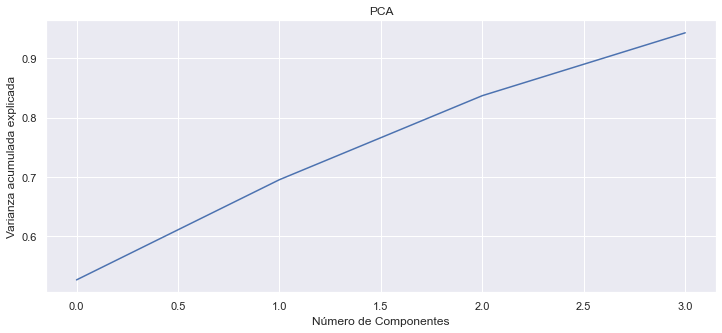

In [95]:

# Crear canvas para colocar figura
plt.figure(figsize=(12, 5))
# Plotear la suma acumulada de la varianza explicada por el PCA
plt.plot(np.cumsum(pca.explained_variance_ratio_))
# Colocar titulo
plt.title('PCA')
# Colocar nombre del eje X
plt.xlabel('Número de Componentes')
# Colocar nombre del eje Y
plt.ylabel('Varianza acumulada explicada');

In [96]:
# Descripcion de cada componente según las variables continuas
pca_df2 = pd.DataFrame(data = pca.components_,
                       columns = sub_df_continuas.columns,
                       index = ['PC1','PC2','PC3','PC4'])

# Mstrar tabla de componentes
pca_df2
                    

,IPCASOS,DESC_FICHABASICA,DESC_PERFILPROMOCIONAL,CONSUMOSTOTAL,CANTIDADLOGIN,PROMEDIO_SESIONES
PC1,0.208439,0.491050,0.362430,0.540882,0.253470,0.476726
PC2,0.640100,-0.284137,0.432037,-0.083106,-0.557111,0.074847
PC3,0.685617,-0.089736,-0.266545,-0.170591,0.632453,-0.147420
PC4,0.260368,0.421521,-0.714172,0.097056,-0.466313,0.132736


Text(0, 0.5, 'Por. varianza explicada')

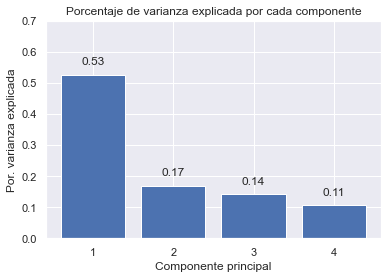

In [97]:
# Crear canvas para colocar figura
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
# Plotear en barras valor de cada componente
ax.bar(
    x      = np.arange(pca.n_components_) + 1,
    height = pca.explained_variance_ratio_
)

# Crear labels para el Eje X y Y (Valores 1, 2, 3, 4 con el valor de cada varianza)
for x, y in zip(np.arange(len(sub_df_continuas.columns)) + 1, pca.explained_variance_ratio_):
    # Crear label de los ejes por componente
    label = round(y, 2)
    # Agregar a la grafica valores por eje
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

# Crear valores para el eje X
ax.set_xticks(np.arange(pca.n_components_) + 1)
# Crear valores para el eje y
ax.set_ylim(0,0.7)
# Crear titulo
ax.set_title('Porcentaje de varianza explicada por cada componente')
# Nombre del eje x
ax.set_xlabel('Componente principal')
# Nombre del eje y
ax.set_ylabel('Por. varianza explicada')

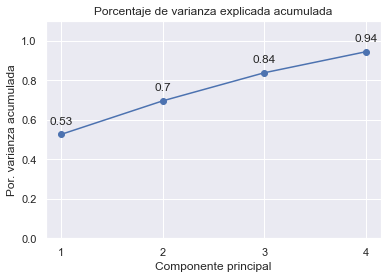

In [98]:
# Calcular varianza acumulada por componente
prop_varianza_acum = pca.explained_variance_ratio_.cumsum()
# Crear canvas para colocar figura
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
# Plotear en linea conitnua valor de cada componente
ax.plot(
    np.arange(pca.n_components_) + 1,
    prop_varianza_acum,
    marker = 'o'
)
# Crear labels para el Eje X y Y (Valores 1, 2, 3, 4 con el valor de cada varianza)
for x, y in zip(np.arange(len(sub_df_continuas.columns)) + 1, prop_varianza_acum):
    # Crear label de los ejes por componente
    label = round(y, 2)
    # Agregar a la grafica valores por eje
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
# Crear valores para el eje y
ax.set_ylim(0, 1.1)
# Crear valores para el eje X
ax.set_xticks(np.arange(pca.n_components_) + 1)
# Crear titulo
ax.set_title('Porcentaje de varianza explicada acumulada')
# Nombre del eje x
ax.set_xlabel('Componente principal')
# Nombre del eje y
ax.set_ylabel('Por. varianza acumulada');

In [99]:
##Uniendo DataFrames (Componentes y variables categoricas del dataframe inicial)
df_1 = pd.concat([pca_df,sub_df[['TIPOUSUARIO','CANAL_REGISTRO','IND_CLIENTE','BONDAD_EMAIL']]],axis=1)
# Mostrando resumen de la tabla final con PCA y demás variables
df_1

,PC1,PC2,PC3,PC4,TIPOUSUARIO,CANAL_REGISTRO,IND_CLIENTE,BONDAD_EMAIL
0,0.649045,-3.218608,2.393756,0.318489,2,1.0,1,20
1,2.344678,-2.334224,1.559222,-0.854870,1,2.0,1,20
2,1.073555,-2.405227,2.253285,-1.676334,2,6.0,1,20
3,2.156667,-1.307849,-0.081079,0.622631,2,1.0,1,20
4,1.240065,-1.029772,0.150662,0.164556,2,4.0,1,20
...,...,...,...,...,...,...,...,...
337825,-0.849072,0.369152,-0.361459,-0.027919,1,9.0,0,20
337826,-0.849072,0.369152,-0.361459,-0.027919,2,2.0,0,20
337827,-0.849072,0.369152,-0.361459,-0.027919,1,2.0,0,0
337828,-0.849072,0.369152,-0.361459,-0.027919,1,8.0,0,20


### Pruebas de Chi-cuadrado para variables categóricas

In [100]:
##Prueba chicuadrado para variables categóricas

##Tipo usuario vs Canal Registro

#Ho: No existe relación entre las variables 
#H1: Existe relación entre las variables

from scipy.stats import chi2_contingency
# Crear tabulación cruzada entre los factores (Tabla de contingencia para TIPOUSUARIO Y CANAL_REGISTRO)
tabla_dobleEntrada = pd.crosstab(df_1['TIPOUSUARIO'],df_1['CANAL_REGISTRO'],margins=True)
# Mostrar tabla de contingencia
print(tabla_dobleEntrada)

##Datos de frecuencia
tabla_dobleEntrada_rel = tabla_dobleEntrada.div(tabla_dobleEntrada['All'],axis=0)
print(tabla_dobleEntrada_rel)

# Estadisticos de la prueba de chi cuadrado
stat, p, dof, esperado = chi2_contingency(tabla_dobleEntrada)
# Valor de confianza
alpha = 0.05
# Mostra el P-value
print("P valor es " + str(p))
# Prueba de hipotesis
if p <= alpha:
  print('Se rechaza Ho: Existe Relación')
else: 
  print('No se tiene la suficiente evidencia estadística para rechazar Ho')

CANAL_REGISTRO    1.0    2.0     3.0    4.0    6.0    7.0    8.0   9.0     All
TIPOUSUARIO                                                                   
1               19109  62888   80125   9756   8160  22726  33891  4538  241193
2                3628  19517   31185   1760   3477  12175  11877  1829   85448
3                 863   1111    5751    358    276   1475   1119   236   11189
All             23600  83516  117061  11874  11913  36376  46887  6603  337830
CANAL_REGISTRO       1.0       2.0       3.0       4.0       6.0       7.0  \
TIPOUSUARIO                                                                  
1               0.079227  0.260737  0.332203  0.040449  0.033832  0.094223   
2               0.042459  0.228408  0.364959  0.020597  0.040691  0.142484   
3               0.077129  0.099294  0.513987  0.031996  0.024667  0.131826   
All             0.069858  0.247213  0.346509  0.035148  0.035263  0.107675   

CANAL_REGISTRO       8.0       9.0  All  
TIPOUSUARIO    

In [101]:
##Prueba chicuadrado para variables categóricas

##Tipo usuario vs Bondad Email

#Ho: No existe relación entre las variables 
#H1: Existe relación entre las variables

from scipy.stats import chi2_contingency
# Crear tabulación cruzada entre los factores (Tabla de contingencia para TIPOUSUARIO Y BONDAD_EMAIL)
tabla_dobleEntrada = pd.crosstab(df_1['TIPOUSUARIO'],df_1['BONDAD_EMAIL'],margins=True)
# Mostrar tabla de contingencia
print(tabla_dobleEntrada)

##Datos de frecuencia
tabla_dobleEntrada_rel = tabla_dobleEntrada.div(tabla_dobleEntrada['All'],axis=0)
print(tabla_dobleEntrada_rel)

# Estadisticos de la prueba de chi cuadrado
stat, p, dof, esperado = chi2_contingency(tabla_dobleEntrada)

# Valor de confianza
alpha = 0.05

# Mostra el P-value
print("P valor es " + str(p))
# Prueba de hipotesis
if p <= alpha:
  print('Se rechaza Ho: Existe Relación')
else: 
  print('No se tiene la suficiente evidencia estadística para rechazar Ho')

BONDAD_EMAIL    -20    -10      0     1     9      20     All
TIPOUSUARIO                                                  
1              8104   9614  33676  3318  2294  184187  241193
2              2591   2123   6711  1261  1461   71301   85448
3               288    449   1377   202   189    8684   11189
All           10983  12186  41764  4781  3944  264172  337830
BONDAD_EMAIL       -20       -10         0         1         9        20  All
TIPOUSUARIO                                                                  
1             0.033600  0.039860  0.139623  0.013757  0.009511  0.763650  1.0
2             0.030323  0.024846  0.078539  0.014758  0.017098  0.834437  1.0
3             0.025740  0.040129  0.123067  0.018053  0.016892  0.776119  1.0
All           0.032510  0.036071  0.123624  0.014152  0.011675  0.781967  1.0
P valor es 0.0
Se rechaza Ho: Existe Relación


In [102]:
##Prueba chicuadrado para variables categóricas
##Canal_Registro vs Bondad Email

#Ho: No existe relación entre las variables 
#H1: Existe relación entre las variables

from scipy.stats import chi2_contingency
# Crear tabulación cruzada entre los factores (Tabla de contingencia para CANAL_REGISTRO Y BONDAD_EMAIL)
tabla_dobleEntrada = pd.crosstab(df_1['CANAL_REGISTRO'],df_1['BONDAD_EMAIL'],margins=True)
# Mostrar tabla de contingencia
print(tabla_dobleEntrada)

##Datos de frecuencia
tabla_dobleEntrada_rel = tabla_dobleEntrada.div(tabla_dobleEntrada['All'],axis=0)
print(tabla_dobleEntrada_rel)

# Estadisticos de la prueba de chi cuadrado
stat, p, dof, esperado = chi2_contingency(tabla_dobleEntrada)

# Valor de confianza
alpha = 0.05

# Mostra el P-value
print("P valor es " + str(p))
# Prueba de hipotesis
if p <= alpha:
  print('Se rechaza Ho: Existe Relación')
else: 
  print('No se tiene la suficiente evidencia estadística para rechazar Ho')

BONDAD_EMAIL      -20    -10      0     1     9      20     All
CANAL_REGISTRO                                                 
1.0               565   2521   7666   187   575   12086   23600
2.0              4033   2461   6853  1243  1109   67817   83516
3.0              3784   3494  13506  1809  1117   93351  117061
4.0               317   1035   3758    91   149    6524   11874
6.0               257    331   1071   151   122    9981   11913
7.0              1026    868   3315   578   390   30199   36376
8.0               990   1313   4938   642   425   38579   46887
9.0                11    163    657    80    57    5635    6603
All             10983  12186  41764  4781  3944  264172  337830
BONDAD_EMAIL         -20       -10         0         1         9        20  \
CANAL_REGISTRO                                                               
1.0             0.023941  0.106822  0.324831  0.007924  0.024364  0.512119   
2.0             0.048290  0.029467  0.082056  0.014883  0.0132

In [103]:
##Prueba chicuadrado para variables categóricas

#Ho: No existe relación entre las variables 
#H1: Existe relación entre las variables

from scipy.stats import chi2_contingency
# Crear tabulación cruzada entre los factores (Tabla de contingencia para IND_CLIENTE Y BONDAD_EMAIL)
tabla_dobleEntrada = pd.crosstab(df_1['IND_CLIENTE'],df_1['BONDAD_EMAIL'],margins=True)
# Mostrar tabla de contingencia
print(tabla_dobleEntrada)

##Datos de frecuencia
tabla_dobleEntrada_rel = tabla_dobleEntrada.div(tabla_dobleEntrada['All'],axis=0)
print(tabla_dobleEntrada_rel)

# Estadisticos de la prueba de chi cuadrado
stat, p, dof, esperado = chi2_contingency(tabla_dobleEntrada)

# Valor de confianza
alpha = 0.05

# Mostra el P-value
print("P valor es " + str(p))
# Prueba de hipotesis
if p <= alpha:
  print('Se rechaza Ho: Existe Relacion')
else: 
  print('No se tiene la suficiente evidencia estadística para rechazar Ho')

BONDAD_EMAIL    -20    -10      0     1     9      20     All
IND_CLIENTE                                                  
0             10965  12178  41726  4762  3926  262551  336108
1                18      8     38    19    18    1621    1722
All           10983  12186  41764  4781  3944  264172  337830
BONDAD_EMAIL       -20       -10         0         1         9        20  All
IND_CLIENTE                                                                  
0             0.032623  0.036232  0.124145  0.014168  0.011681  0.781151  1.0
1             0.010453  0.004646  0.022067  0.011034  0.010453  0.941347  1.0
All           0.032510  0.036071  0.123624  0.014152  0.011675  0.781967  1.0
P valor es 6.99363363247597e-52
Se rechaza Ho: Existe Relacion


In [104]:
##Prueba chicuadrado para variables categóricas

#Ho: No existe relación entre las variables 
#H1: Existe relación entre las variables

from scipy.stats import chi2_contingency
# Crear tabulación cruzada entre los factores (Tabla de contingencia para IND_CLIENTE Y CANAL_REGISTRO)
tabla_dobleEntrada = pd.crosstab(df_1['IND_CLIENTE'],df_1['CANAL_REGISTRO'],margins=True)
# Mostrar tabla de contingencia
print(tabla_dobleEntrada)

##Datos de frecuencia
tabla_dobleEntrada_rel = tabla_dobleEntrada.div(tabla_dobleEntrada['All'],axis=0)
print(tabla_dobleEntrada_rel)

# Estadisticos de la prueba de chi cuadrado
stat, p, dof, esperado = chi2_contingency(tabla_dobleEntrada)

# Valor de confianza
alpha = 0.05

# Mostra el P-value
print("P valor es " + str(p))
# Prueba de hipotesis
if p <= alpha:
  print('Se rechaza Ho: Existe Relación')
else: 
  print('No se tiene la suficiente evidencia estadística para rechazar Ho')

CANAL_REGISTRO    1.0    2.0     3.0    4.0    6.0    7.0    8.0   9.0     All
IND_CLIENTE                                                                   
0               23237  83261  116714  11697  11832  36029  46770  6568  336108
1                 363    255     347    177     81    347    117    35    1722
All             23600  83516  117061  11874  11913  36376  46887  6603  337830
CANAL_REGISTRO       1.0       2.0       3.0       4.0       6.0       7.0  \
IND_CLIENTE                                                                  
0               0.069136  0.247721  0.347251  0.034801  0.035203  0.107195   
1               0.210801  0.148084  0.201510  0.102787  0.047038  0.201510   
All             0.069858  0.247213  0.346509  0.035148  0.035263  0.107675   

CANAL_REGISTRO       8.0       9.0  All  
IND_CLIENTE                              
0               0.139152  0.019541  1.0  
1               0.067944  0.020325  1.0  
All             0.138789  0.019545  1.0  
P va

In [105]:
##Prueba chicuadrado para variables categóricas

#Ho: No existe relación entre las variables 
#H1: Existe relación entre las variables

from scipy.stats import chi2_contingency

# Crear tabulación cruzada entre los factores (Tabla de contingencia para TIPOUSUARIO Y CANAL_REGISTRO)
tabla_dobleEntrada = pd.crosstab(df_1['IND_CLIENTE'],df_1['TIPOUSUARIO'],margins=True)
# Mostrar tabla de contingencia
print(tabla_dobleEntrada)

##Datos de frecuencia
tabla_dobleEntrada_rel = tabla_dobleEntrada.div(tabla_dobleEntrada['All'],axis=0)
print(tabla_dobleEntrada_rel)

# Estadisticos de la prueba de chi cuadrado
stat, p, dof, esperado = chi2_contingency(tabla_dobleEntrada)

# Valor de confianza
alpha = 0.05

# Mostra el P-value
print("P valor es " + str(p))
# Prueba de hipotesis
if p <= alpha:
  print('Se rechaza Ho: Existe Relación')
else: 
  print('No se tiene la suficiente evidencia estadística para rechazar Ho')

TIPOUSUARIO       1      2      3     All
IND_CLIENTE                              
0            240394  84611  11103  336108
1               799    837     86    1722
All          241193  85448  11189  337830
TIPOUSUARIO         1         2         3  All
IND_CLIENTE                                   
0            0.715228  0.251738  0.033034  1.0
1            0.463995  0.486063  0.049942  1.0
All          0.713948  0.252932  0.033120  1.0
P valor es 5.016477786107073e-113
Se rechaza Ho: Existe Relación


In [106]:
# De acuerdo a las pruebas de Chi_cuadrado no hay dependencia entre las variables por lo cual no se elimina ninguna

# Mostrar resumen del dataframe
df_1

,PC1,PC2,PC3,PC4,TIPOUSUARIO,CANAL_REGISTRO,IND_CLIENTE,BONDAD_EMAIL
0,0.649045,-3.218608,2.393756,0.318489,2,1.0,1,20
1,2.344678,-2.334224,1.559222,-0.854870,1,2.0,1,20
2,1.073555,-2.405227,2.253285,-1.676334,2,6.0,1,20
3,2.156667,-1.307849,-0.081079,0.622631,2,1.0,1,20
4,1.240065,-1.029772,0.150662,0.164556,2,4.0,1,20
...,...,...,...,...,...,...,...,...
337825,-0.849072,0.369152,-0.361459,-0.027919,1,9.0,0,20
337826,-0.849072,0.369152,-0.361459,-0.027919,2,2.0,0,20
337827,-0.849072,0.369152,-0.361459,-0.027919,1,2.0,0,0
337828,-0.849072,0.369152,-0.361459,-0.027919,1,8.0,0,20


#### Selección de características

In [107]:
sub_df = df_1
# Convertir columna CANAL_REGISTRO a tipo entero
sub_df['CANAL_REGISTRO'] = sub_df['CANAL_REGISTRO'].astype(int)
# Convertir columna TIPOUSUARIO a tipo entero
sub_df['TIPOUSUARIO'] = sub_df['TIPOUSUARIO'].astype(int)
# Convertir columna BONDAD_EMAIL a tipo entero
sub_df['BONDAD_EMAIL'] = sub_df['BONDAD_EMAIL'].astype(int)

In [108]:
# Crear tabla dinamica con valores (Contar) por IND_CLIENTE y BONDAD_EMAIL
sub_df.groupby(['IND_CLIENTE', 'BONDAD_EMAIL'])[['IND_CLIENTE']].count()

IND_CLIENTE
IND_CLIENTE BONDAD_EMAIL             
0           -20                 10965
            -10                 12178
             0                  41726
             1                   4762
             9                   3926
             20                262551
1           -20                    18
            -10                     8
             0                     38
             1                     19
             9                     18
             20                  1621

In [109]:
# Por 2 razones se deciden eliminar las subcategorias -20, -10, 0 y 1 de BONDAD_EMAIL
# La primera porque el correo de acuerdo a la Bondad del email no existe, es inválido de forma pemanente o envia la campaña a Spam
# Segundo, porque al eliminar esos registros se estan eliminando 21% de registros que no son clientes vs solo 4.8% que se elimnan que si lo son.

In [110]:
# Eliminar valores de BONDAD_EMAIL que sean -10, 0, -20 y 1
temp_df = sub_df[(sub_df['BONDAD_EMAIL'] != -10) & (sub_df['BONDAD_EMAIL'] != 0) & (sub_df['BONDAD_EMAIL'] != -20) & (sub_df['BONDAD_EMAIL'] != 1)]
# Reemplazar columna BONDAD_EMAIL por su version en tipo categoría
temp_df['BONDAD_EMAIL'] = temp_df['BONDAD_EMAIL'].astype('category')

# Reemplazar dataframe inicial por el filtro aplicado a BONDAD_EMAIL
sub_df = temp_df
# Crear vista de tabla dinamica (Contar) por IND_CLIENTE y BONDAD_EMAIL
sub_df.groupby(['IND_CLIENTE', 'BONDAD_EMAIL'])[['IND_CLIENTE']].count()

IND_CLIENTE
IND_CLIENTE BONDAD_EMAIL             
0           9                    3926
            20                 262551
1           9                      18
            20                   1621

In [111]:
# Crear tabla dinamica con valores (Contar) por IND_CLIENTE
sub_df.groupby(['IND_CLIENTE'])[['IND_CLIENTE']].count()

,IND_CLIENTE
IND_CLIENTE,
0,266477
1,1639


In [112]:
# Crear tabla dinamica con valores (Contar) por IND_CLIENTE y CANAL_REGISTRO
sub_df.groupby(['IND_CLIENTE', 'CANAL_REGISTRO'])[['IND_CLIENTE']].count()

IND_CLIENTE
IND_CLIENTE CANAL_REGISTRO             
0           1                     12329
            2                     68677
            3                     94133
            4                      6507
            6                     10028
            7                     30256
            8                     38890
            9                      5657
1           1                       332
            2                       249
            3                       335
            4                       166
            6                        75
            7                       333
            8                       114
            9                        35

In [113]:
# Crear tabla dinamica con valores (Contar) por IND_CLIENTE y TIPOUSUARIO
sub_df.groupby(['IND_CLIENTE', 'TIPOUSUARIO'])[['IND_CLIENTE']].count()

IND_CLIENTE
IND_CLIENTE TIPOUSUARIO             
0           1                 185713
            2                  71973
            3                   8791
1           1                    768
            2                    789
            3                     82

In [114]:
# Crear tabla dinamica con valores (Contar) por IND_CLIENTE
sub_df.groupby(['IND_CLIENTE'])[['IND_CLIENTE']].count()

,IND_CLIENTE
IND_CLIENTE,
0,266477
1,1639


In [115]:
# Convertir columna CANAL_REGISTRO a tipo category
sub_df['CANAL_REGISTRO'] = sub_df['CANAL_REGISTRO'].astype('category')
# Convertir columna TIPOUSUARIO a tipo category
sub_df['TIPOUSUARIO'] = sub_df['TIPOUSUARIO'].astype('category')

In [116]:
df_final = sub_df
df_final

,PC1,PC2,PC3,PC4,TIPOUSUARIO,CANAL_REGISTRO,IND_CLIENTE,BONDAD_EMAIL
0,0.649045,-3.218608,2.393756,0.318489,2,1,1,20
1,2.344678,-2.334224,1.559222,-0.854870,1,2,1,20
2,1.073555,-2.405227,2.253285,-1.676334,2,6,1,20
3,2.156667,-1.307849,-0.081079,0.622631,2,1,1,20
4,1.240065,-1.029772,0.150662,0.164556,2,4,1,20
...,...,...,...,...,...,...,...,...
337824,-0.896223,-1.263893,0.722060,1.278385,2,4,0,20
337825,-0.849072,0.369152,-0.361459,-0.027919,1,9,0,20
337826,-0.849072,0.369152,-0.361459,-0.027919,2,2,0,20
337828,-0.849072,0.369152,-0.361459,-0.027919,1,8,0,20


In [117]:
# Crear nombre final para el dataset final
file_name = "todoslosclientes.csv"
# Exportar a csv
df_final.to_csv(file_name, sep=';')

# Técnicas de Balanceo de Datos

In [118]:
# Crear dataframe X con el dataframe sin la columna de IND_CLIENTE
X = df_final.drop(['IND_CLIENTE'], axis=1)
# Algoritmo de OneHot Encoder para las columnas del dataframe X
X = pd.get_dummies(X)
# Crear dataframe Y con la columna de IND_CLIENTE
y = df_final['IND_CLIENTE']



In [119]:
# Se dividen los datos en entrenamiento (80%) y prueba (20%) datos
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=.2)

In [120]:
def construiryevaluar_modelo(model, model_name):
    # Activar variabkles globales que serán modificadas con cada modelo de balanceo
    global X_train_balanced, y_train_balanced
    '''Función para construir el modelo y evaluar el rendimiento'''
    # Entrenando el modelo
    model.fit(X_train_balanced, y_train_balanced)
    # Obteniendo puntuación de validación cruzada kfold
    scores = cross_val_score(model, X_train_balanced, y_train_balanced, cv=5)
    # Se predicen los datos de prueba
    y_pred = model.predict(X_test)
    # Guardando el valor de exactitud
    exactitud = accuracy_score(y_test, y_pred)
    # Imprimiendo puntaje de la exactitud
    print("Exactitud: %0.3f" % exactitud)
    # Imprimiendo puntaje de la validación cruzada
    print("Validación Cruzada: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    # Impimiendo reporte de la precision, recall, f1 score, soporte
    print(classification_report(y_test, y_pred))
    # Imprimiendo la matriz de confusión
    plot_confusion_matrix(model ,X_test, y_test)
    # Agregar titulo al grafico
    plt.title('Matriz de Confusión ' + model_name)
    # Mostrar grafico
    plt.show()
    
    # Guardando el valor de precision
    precision = precision_score(y_test, y_pred, average='macro')
    # Guardando el valor de recall
    recall = recall_score(y_test, y_pred, average='macro')
    # Guardando f1 score
    f1 = 2*((precision * recall) / (precision + recall))
    # Guardando f2 score
    f2 = 5 * (precision * recall) / ((4 * precision) + recall)


    
    #  Retornando la Matriz de Evaluación
    return {'Nombre del Modelo': model_name,
           'Validación Cruzada': scores.mean(),
           'Exactitud': exactitud,
           'Precisión': precision,
           'Recall': recall,
           'F1-Score': f1,
           'F2-Score': f2
           }

In [121]:
# Crear dataframes (Sin balancear) como punto de comparación con los demas
X_train_balanced, y_train_balanced = (X_train, y_train)


In [122]:
# Calcular cantida de valores por indicativo de cliente
y_train_balanced.value_counts()

0    213208
1      1284
Name: IND_CLIENTE, dtype: int64

Exactitud: 0.993
Validación Cruzada: 0.994 (+/- 0.00)
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     53269
           1       0.47      0.06      0.10       355

    accuracy                           0.99     53624
   macro avg       0.73      0.53      0.55     53624
weighted avg       0.99      0.99      0.99     53624



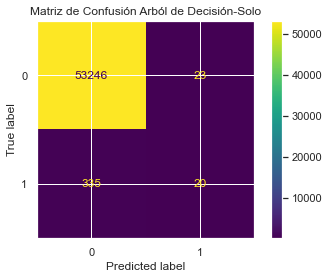

In [123]:
# Crear lista con el resultado de cada modelo del balanceo
results = []
# Evaluar modelo de Arboles de decision sin balanceo de datos
results.append(construiryevaluar_modelo(DecisionTreeClassifier(random_state=0, max_depth=8), 'Arból de Decisión-Solo'))

## Sobremuestreo Aleatorio

In [124]:
# Crear instancia del algoritmo de Sobremuestreo Aleatorio
randover = RandomOverSampler(sampling_strategy='auto', random_state=0)
# Balancear el dataframe con el modelo
X_train_balanced, y_train_balanced = randover.fit_resample(X_train, y_train)

In [125]:
# Calcular cantida de valores por indicativo de cliente
#  (Con la tecnica de balanceo aplicada)
y_train_balanced.value_counts()

0    213208
1    213208
Name: IND_CLIENTE, dtype: int64

Exactitud: 0.853
Validación Cruzada: 0.911 (+/- 0.00)
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     53269
           1       0.04      0.91      0.08       355

    accuracy                           0.85     53624
   macro avg       0.52      0.88      0.50     53624
weighted avg       0.99      0.85      0.91     53624



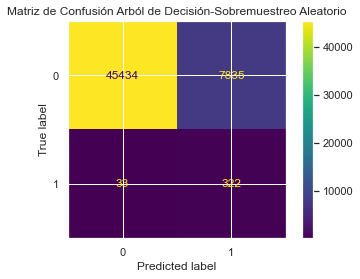

In [126]:
# Evaluar modelo de Arboles de decision con balanceo de datos
# bajo el metodo de Sobremuestreo Aleatorio
results.append(construiryevaluar_modelo(DecisionTreeClassifier(random_state=0, max_depth=8), 'Arból de Decisión-Sobremuestreo Aleatorio'))

## Submuestreo Aleatorio

In [127]:
# Crear instancia del algoritmo de submuestreo Aleatorio
randunder = RandomUnderSampler(sampling_strategy='auto', random_state=0)
# Balancear el dataframe con el modelo
X_train_balanced, y_train_balanced = randunder.fit_resample(X_train, y_train)

In [128]:
# Calcular cantida de valores por indicativo de cliente
#  (Con la tecnica de balanceo aplicada)
y_train_balanced.value_counts()

0    1284
1    1284
Name: IND_CLIENTE, dtype: int64

Exactitud: 0.811
Validación Cruzada: 0.871 (+/- 0.02)
              precision    recall  f1-score   support

           0       1.00      0.81      0.89     53269
           1       0.03      0.95      0.06       355

    accuracy                           0.81     53624
   macro avg       0.52      0.88      0.48     53624
weighted avg       0.99      0.81      0.89     53624



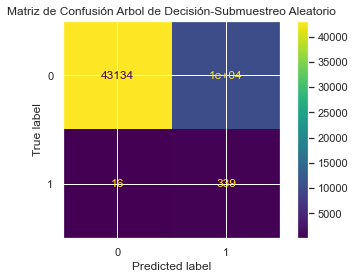

In [129]:
# Evaluar modelo de Arboles de decision con balanceo de datos
# bajo el metodo de Submuestreo Aleatorio
results.append(construiryevaluar_modelo(DecisionTreeClassifier(random_state=0, max_depth=8), 'Arbol de Decisión-Submuestreo Aleatorio'))

## Smote-Técnica de Sobremuestreo

In [130]:
# Crear instancia del algoritmo SMOTE
smote = SMOTE(random_state=0)
# Balancear el dataframe con el modelo
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [131]:
# Calcular cantida de valores por indicativo de cliente
#  (Con la tecnica de balanceo aplicada)
y_train_balanced.value_counts()

0    213208
1    213208
Name: IND_CLIENTE, dtype: int64

Exactitud: 0.875
Validación Cruzada: 0.913 (+/- 0.00)
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     53269
           1       0.05      0.88      0.09       355

    accuracy                           0.88     53624
   macro avg       0.52      0.88      0.51     53624
weighted avg       0.99      0.88      0.93     53624



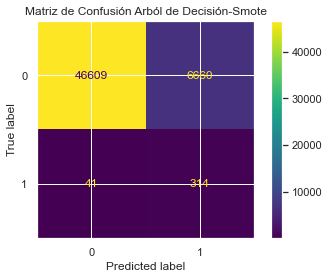

In [132]:
# Evaluar modelo de Arboles de decision con balanceo de datos
# bajo el metodo de SMOTE
results.append(construiryevaluar_modelo(DecisionTreeClassifier(random_state=0, max_depth=8), 'Arból de Decisión-Smote'))

## OneSidedSelection-Técnica de Submuestreo

In [133]:
# Crear instancia del algoritmo de OneSidedSelection
onesided = OneSidedSelection(random_state=0)
# Balancear el dataframe con el modelo
X_train_balanced, y_train_balanced = onesided.fit_resample(X_train, y_train)

In [134]:
# Calcular cantida de valores por indicativo de cliente
#  (Con la tecnica de balanceo aplicada)
y_train_balanced.value_counts()

0    184359
1      1284
Name: IND_CLIENTE, dtype: int64

Exactitud: 0.993
Validación Cruzada: 0.993 (+/- 0.00)
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     53269
           1       0.50      0.08      0.14       355

    accuracy                           0.99     53624
   macro avg       0.75      0.54      0.57     53624
weighted avg       0.99      0.99      0.99     53624



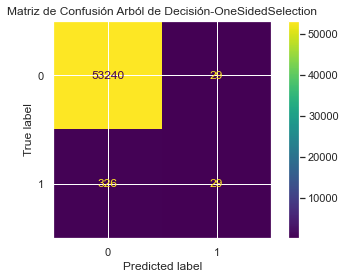

In [135]:
# Evaluar modelo de Arboles de decision con balanceo de datos
# bajo el metodo OneSidedSelection
results.append(construiryevaluar_modelo(DecisionTreeClassifier(random_state=0, max_depth=8), 'Arból de Decisión-OneSidedSelection'))

## Comparación

In [136]:
# Crear tabla con los resultados de cada modelo de balanceo
# Y ordenar de mayor a menor por el F2-Score
per_df = pd.json_normalize(results).set_index('Nombre del Modelo').sort_values(['F2-Score'],  ascending = False)
# Mostrar tabla de resultados
per_df


,Validación Cruzada,Exactitud,Precisión,Recall,F1-Score,F2-Score
Nombre del Modelo,,,,,,
Arból de Decisión-Smote,0.912857,0.875037,0.522073,0.879741,0.655278,0.773726
Arból de Decisión-Sobremuestreo Aleatorio,0.911441,0.853275,0.519375,0.879979,0.653214,0.772684
Arbol de Decisión-Submuestreo Aleatorio,0.870721,0.810700,0.515998,0.882334,0.651179,0.772628
Arból de Decisión-OneSidedSelection,0.993245,0.993380,0.746957,0.540573,0.627224,0.572192
Arból de Decisión-Solo,0.994144,0.993324,0.729432,0.527953,0.612550,0.558824


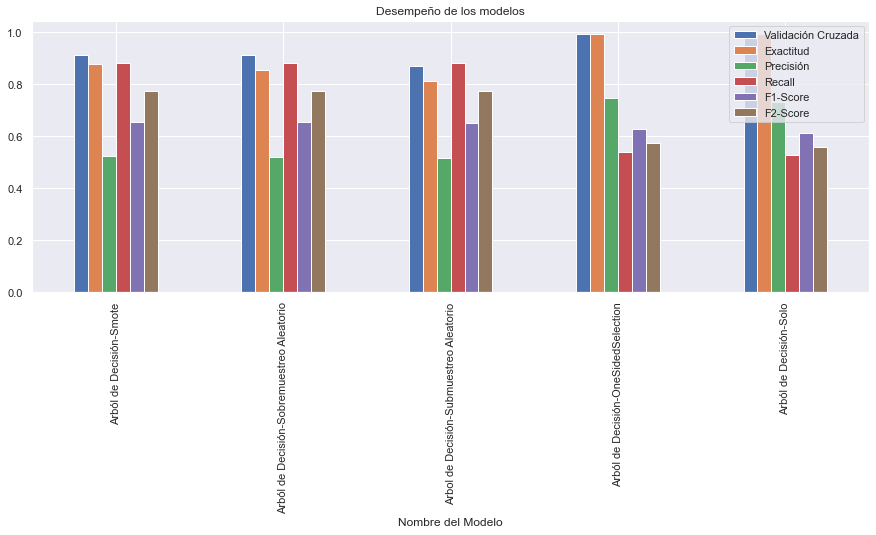

In [137]:
# Crear grafica de barras con los resultados de cada modelo de balanceo de datos
per_df.plot(kind='bar', figsize=(15, 5), title='Desempeño de los modelos');

In [138]:
# De acuerdo a los resultados obtenidos la mejor tecnica fue:
# SMOTE= Los valores de validacion cruzada, exactitud, precision, recall, f1 y f2 score son mejores en este

# Generando otros modelos de clasificación con la mejor técnica de balanceo de datos

In [139]:
# Crear instancia del algoritmo SMOTE
smote = SMOTE(random_state=0)
# Balancear el dataframe con el modelo
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [140]:
# Calcular cantida de valores por indicativo de cliente
#  (Con la tecnica de balanceo aplicada)
y_train_balanced.value_counts()

0    213208
1    213208
Name: IND_CLIENTE, dtype: int64

## Regresión Logística

Exactitud: 0.874
Validación Cruzada: 0.849 (+/- 0.00)
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     53269
           1       0.04      0.77      0.07       355

    accuracy                           0.87     53624
   macro avg       0.52      0.82      0.50     53624
weighted avg       0.99      0.87      0.93     53624



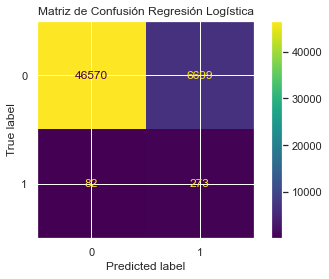

In [141]:
# Crear lista con los resultados de cada modelo
results = []
# Evaluar modelo de Regresion Logistica con balanceo de datos
# bajo el metodo de SMOTE
results.append(construiryevaluar_modelo(LogisticRegression(random_state=0), 'Regresión Logística'))

## Random Forest

Exactitud: 0.987
Validación Cruzada: 0.994 (+/- 0.00)
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     53269
           1       0.21      0.33      0.25       355

    accuracy                           0.99     53624
   macro avg       0.60      0.66      0.62     53624
weighted avg       0.99      0.99      0.99     53624



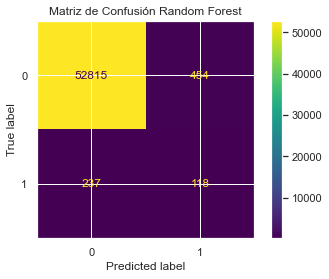

In [142]:
# Evaluar modelo de Random Forest con balanceo de datos
# bajo el metodo  de SMOTE
results.append(construiryevaluar_modelo(RandomForestClassifier(random_state=0, n_jobs=-1), 'Random Forest'))

## Gradient Boosting

Exactitud: 0.867
Validación Cruzada: 0.910 (+/- 0.00)
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     53269
           1       0.04      0.90      0.08       355

    accuracy                           0.87     53624
   macro avg       0.52      0.88      0.51     53624
weighted avg       0.99      0.87      0.92     53624



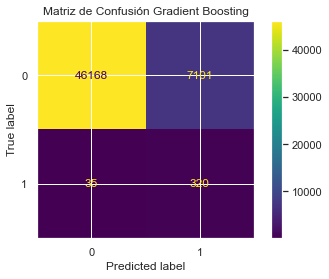

In [143]:
# Evaluar modelo de Gradient Boosting con balanceo de datos
# bajo el metodo de SMOTE
results.append(construiryevaluar_modelo(GradientBoostingClassifier(random_state=0), 'Gradient Boosting'))

## AdaBoosting

Exactitud: 0.851
Validación Cruzada: 0.885 (+/- 0.00)
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     53269
           1       0.04      0.89      0.07       355

    accuracy                           0.85     53624
   macro avg       0.52      0.87      0.50     53624
weighted avg       0.99      0.85      0.91     53624



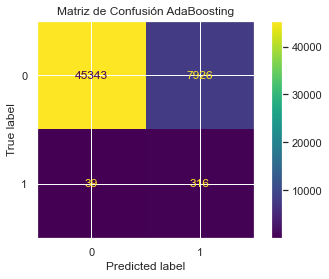

In [144]:
# Evaluar modelo de AdaBoosting con balanceo de datos
# bajo el metodo de SMOTE
results.append(construiryevaluar_modelo(AdaBoostClassifier(random_state=0), 'AdaBoosting'))


## Arbol de decisión

Exactitud: 0.875
Validación Cruzada: 0.913 (+/- 0.00)
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     53269
           1       0.05      0.88      0.09       355

    accuracy                           0.88     53624
   macro avg       0.52      0.88      0.51     53624
weighted avg       0.99      0.88      0.93     53624



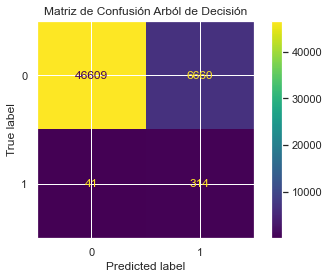

In [145]:
# Evaluar modelo de Arbol de decisión con balanceo de datos
# bajo el metodo de SMOTE
results.append(construiryevaluar_modelo(DecisionTreeClassifier(random_state=0, max_depth=8), 'Arból de Decisión'))

## Comparación de modelos

In [146]:
# Crear tabla con el resumen de los resultados de los modelos
# Y ordenar de mayor a menor por el F2-Score
per_df = pd.json_normalize(results).set_index('Nombre del Modelo').sort_values(['F2-Score'],  ascending = False)
# Mostrar tabla con el resumen de resultados por modelo
per_df

,Validación Cruzada,Exactitud,Precisión,Recall,F1-Score,F2-Score
Nombre del Modelo,,,,,,
Gradient Boosting,0.910085,0.866925,0.521182,0.884052,0.655765,0.775995
Arból de Decisión,0.912857,0.875037,0.522073,0.879741,0.655278,0.773726
AdaBoosting,0.884767,0.851466,0.518740,0.870674,0.650136,0.766649
Regresión Logística,0.849075,0.873545,0.518699,0.821628,0.635931,0.735696
Random Forest,0.993649,0.987114,0.600913,0.661936,0.629950,0.648760


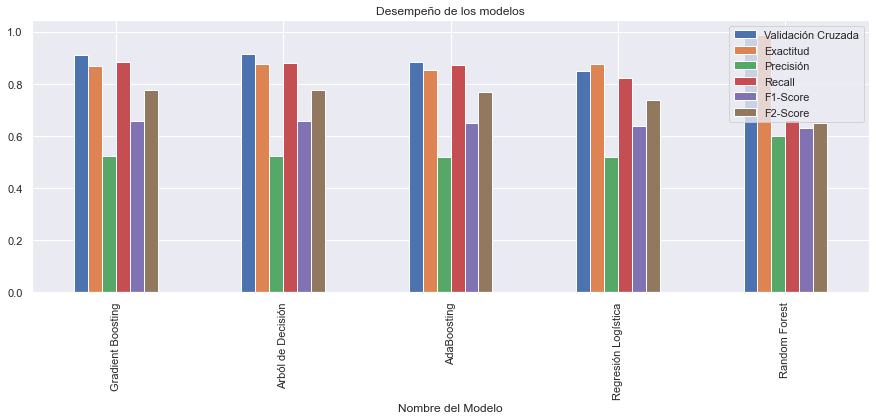

In [147]:
# Crear grafico con el resultado de cada modelo
per_df.plot(kind='bar', figsize=(15, 5), title='Desempeño de los modelos');

In [148]:
# De acuerdo a los resultados existen dos algoritmos que Clasifican ganadores:
# Arbol de Decision y Gradient Boosting
# Sin embargo, Gradient boosting tiene mejor F2-Score y Recall

In [149]:
# Se utilizará el mejor modelo para mirar variables importantes
model = GradientBoostingClassifier(random_state=0)
model.fit(X_train_balanced, y_train_balanced)
list(model.feature_importances_)

[0.7738977846181182,
 0.08073244071033919,
 0.038129248103969164,
 0.055297790633496526,
 0.01638736266865015,
 0.00046498952940370443,
 0.0026872543178704297,
 0.0017763198101583095,
 0.004039626062178336,
 0.009750525937685871,
 0.0013994877551479405,
 0.0005161183756965947,
 0.002510395789435091,
 0.0076783007759826565,
 0.0022152495426764132,
 0.0018326532240921052,
 0.000684452145099278]

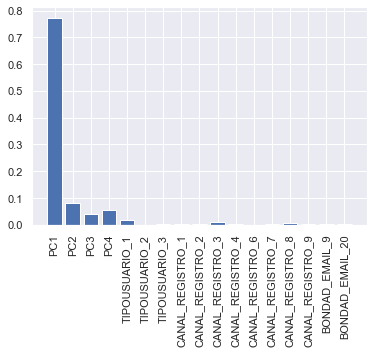

In [150]:
# Graficando a importancia de las variables 
from matplotlib import pyplot
pyplot.bar(X_train_balanced.columns, model.feature_importances_)
plt.xticks(rotation = 90)
pyplot.show()

In [151]:
# Creando una tabla con la importancia de las variables ordenada de forma descendente
var_importancia=list(model.feature_importances_)
Nombre_var_fact=list(X_train_balanced.columns)

importancia_features_RF= pd.DataFrame(list(zip(Nombre_var_fact, var_importancia)), columns=['variable', 'importancia'])
importancia_features_RF.sort_values(['importancia'],ascending=False)

,variable,importancia
0,PC1,0.773898
1,PC2,0.080732
3,PC4,0.055298
2,PC3,0.038129
4,TIPOUSUARIO_1,0.016387
9,CANAL_REGISTRO_3,0.009751
13,CANAL_REGISTRO_8,0.007678
8,CANAL_REGISTRO_2,0.004040
6,TIPOUSUARIO_3,0.002687
12,CANAL_REGISTRO_7,0.002510


In [152]:
# Predicción de la base de clientes totales con el modelo que arrojó las mejores metricas Gradient B. (Esta predicción es binaria)
y_pred = model.predict(X)
y_pred

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [153]:
# Predicción de la base de clientes totales para los clientes potenciales (Probabilidad)
predictions2_proba=model.predict_proba(X)[:,1]
predictions2_proba

array([0.89813736, 0.86299108, 0.92230155, ..., 0.00742441, 0.00720864,
       0.04875272])

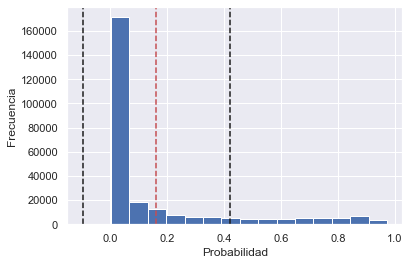

In [154]:
# Graficando la distribución de la predicción con la media + o - 1 desviación
fig,ax=plt.subplots()
ax.hist(predictions2_proba,bins=15)
# plt.hist(prob_pago,bins=10)
ax.set_xlabel('Probabilidad')
ax.set_ylabel('Frecuencia')
plt.axvline(np.mean(predictions2_proba),c='r',linestyle='--',label='Promedio')
plt.axvline(np.mean(predictions2_proba)+np.std(predictions2_proba),c='k',linestyle='--',label='+1desv')
plt.axvline(np.mean(predictions2_proba)-np.std(predictions2_proba),c='k',linestyle='--',label='-1desv')

plt.show()

In [155]:
# Agregando las predcciones en probabilidades y binarias a la data inicial
X['predict'] = predictions2_proba
X['predict_binario']=y_pred

In [156]:
# Mirando la proporción de la predicción binaria (0 y 1)
print(X.groupby('predict_binario').size()/len(X))

predict_binario
0    0.860736
1    0.139264
dtype: float64


In [157]:
# Agrupando la predicción de probabilidades en rangos de 10 puntos
bins_proba=[0,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1]
names_proba=["0-10%","10%-20%","20%-30%","30%-40%","40%-50%","50%-60%","60%-70%","70%-80%","80%-90%","90%-100%"]
X['predict_rangos']=pd.cut(X['predict'],bins_proba,labels=names_proba,right=True)
print(X.groupby('predict_rangos').size()/len(X))

predict_rangos
0-10%       0.678065
10%-20%     0.079536
20%-30%     0.041639
30%-40%     0.032650
40%-50%     0.028846
50%-60%     0.027089
60%-70%     0.028104
70%-80%     0.029099
80%-90%     0.037812
90%-100%    0.017160
dtype: float64


In [158]:
# Ahora se realizará el trabajo para usuarios que se convirtieron en clientes
# despues de la fecha de registro